In [526]:
import os
from glob import glob
import re
from parse import parse, findall
from collections import defaultdict
from itertools import product

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm
tqdm.pandas()

from pandarallel import pandarallel

pandarallel.initialize(progress_bar=True)

#from process import make_dataframe

pd.set_option("display.max_rows", None, "display.max_columns", None, 'display.max_colwidth', None)

import ipdb

INFO: Pandarallel will run on 24 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


# read in data

In [625]:
#files = glob('./clean_results300/*/*/results*.txt', recursive=True)
files = glob('./clean_results500/*/*/results*.txt', recursive=True)



In [626]:
len(files)

6300

In [627]:
df = pd.DataFrame({'path':files})
df.head()

path
0   ./clean_results500/orig_algorithm_svrtol=0.0001_ntk-norm=True_diri-inclx=True_diri-sf=4/test_size=0.9_shadow_size=100_qubits_d=1/results_4x5_new_data.txt
1  ./clean_results500/orig_algorithm_svrtol=0.0001_ntk-norm=True_diri-inclx=True_diri-sf=4/test_size=0.9_shadow_size=100_qubits_d=1/results_4x5_orig_data.txt
2   ./clean_results500/orig_algorithm_svrtol=0.0001_ntk-norm=True_diri-inclx=True_diri-sf=4/test_size=0.9_shadow_size=100_qubits_d=1/results_8x5_new_data.txt
3   ./clean_results500/orig_algorithm_svrtol=0.0001_ntk-norm=True_diri-inclx=True_diri-sf=4/test_size=0.9_shadow_size=100_qubits_d=1/results_9x5_new_data.txt
4  ./clean_results500/orig_algorithm_svrtol=0.0001_ntk-norm=True_diri-inclx=True_diri-sf=4/test_size=0.9_shadow_size=100_qubits_d=1/results_9x5_orig_data.txt

In [628]:
%pdb on

def extract(row):
    if 'new_algorithm' in row.path:
        row = extract_new(row)
    else:
        row = extract_orig(row)
    
    row['algo_setting'] = row.path.split(os.sep)[2]
    return row

def extract_new(row):
    if 'celer' in row.path:
        pat = "{}new_algorithm_{lassolib}_maxiter={maxiter:d}_maxep={maxep:d}_tol={tol:f}/test_size={testsize:f}_shadow_size={shadowsize:d}_qubits_d={qubitdist:d}/results_{nrow:d}x{ncol:d}_{dataname}_data.txt"
    elif 'sklearn' in row.path:
        pat = "{}new_algorithm_{lassolib}_maxiter={maxiter:d}_tol={tol:f}/test_size={testsize:f}_shadow_size={shadowsize:d}_qubits_d={qubitdist:d}/results_{nrow:d}x{ncol:d}_{dataname}_data.txt"
    
    
    temp = parse(pat, row.path)
    temp = pd.Series(temp.named)
    temp['path'] = row.path
    temp['algo'] = 'new'
    return temp
    
def extract_orig(row):
    pat = "{}orig_algorithm_svrtol={srvtol:f}_ntk-norm={ntknorm}_diri-inclx={dirinclx}_diri-sf={dirsf:d}/test_size={testsize:f}_shadow_size={shadowsize:d}_qubits_d={qubitdist:d}/results_{nrow:d}x{ncol:d}_{dataname}_data.txt"
    
    temp = parse(pat, row.path)
    temp = pd.Series(temp.named)
    temp['path'] = row.path
    temp['algo'] = 'orig'
    return temp

Automatic pdb calling has been turned ON


In [629]:
df = df.parallel_apply(extract, axis=1)
df.head()

srvtol ntknorm dirinclx  dirsf  testsize  shadowsize  qubitdist  nrow  \
0  0.0001    True     True    4.0       0.9         100          1     4   
1  0.0001    True     True    4.0       0.9         100          1     4   
2  0.0001    True     True    4.0       0.9         100          1     8   
3  0.0001    True     True    4.0       0.9         100          1     9   
4  0.0001    True     True    4.0       0.9         100          1     9   

   ncol dataname  \
0     5      new   
1     5     orig   
2     5      new   
3     5      new   
4     5     orig   

                                                                                                                                                         path  \
0   ./clean_results500/orig_algorithm_svrtol=0.0001_ntk-norm=True_diri-inclx=True_diri-sf=4/test_size=0.9_shadow_size=100_qubits_d=1/results_4x5_new_data.txt   
1  ./clean_results500/orig_algorithm_svrtol=0.0001_ntk-norm=True_diri-inclx=True_diri-sf=4/test_size=0.9_shadow_size=100_qubits_d=1/results_4x5_orig_data.txt   
2   ./clean_results500/orig_algorithm_svrtol=0.0001_ntk-norm=True_diri-inclx=True_diri-sf=4/test_size=0.9_shadow_size=100_qubits_d=1/results_8x5_new_data.txt   
3   ./clean_results500/orig_algorithm_svrtol=0.0001_ntk-norm=True_diri-inclx=True_diri-sf=4/test_size=0.9_shadow_size=100_qubits_d=1/results_9x5_new_data.txt   
4  ./clean_results500/orig_algorithm_svrtol=0.0001_ntk-norm=True_diri-inclx=True_diri-sf=4/test_size=0.9_shadow_size=100_qubits_d=1/results_9x5_orig_data.txt   

   algo                                                          algo_setting  \
0  orig  orig_algorithm_svrtol=0.0001_ntk-norm=True_diri-inclx=True_diri-sf=4   
1  orig  orig_algorithm_svrtol=0.0001_ntk-norm=True_diri-inclx=True_diri-sf=4   
2  orig  orig_algorithm_svrtol=0.0001_ntk-norm=True_diri-inclx=True_diri-sf=4   
3  orig  orig_algorithm_svrtol=0.0001_ntk-norm=True_diri-inclx=True_diri-sf=4   
4  orig  orig_algorithm_svrtol=0.0001_ntk-norm=True_diri-inclx=True_diri-sf=4   

  lassolib  maxep  maxiter  tol  
0      NaN    NaN      NaN  NaN  
1      NaN    NaN      NaN  NaN  
2      NaN    NaN      NaN  NaN  
3      NaN    NaN      NaN  NaN  
4      NaN    NaN      NaN  NaN

In [630]:
%pdb on
def read_results(row):
    if row['algo'] == 'new':
        return read_results_new(row)
    elif row['algo'] == 'orig':
        return read_results_orig(row)

def read_results_new(row):
    
    pat1 = "(q1, q2) = ({:d}, {:d})"
    pat2 = "({:g}, {:g})"
    
    edges = []
    best_cv_score = []
    test_score = []
    with open(row.path, 'r') as f:
        try:
            for lnum, line in enumerate(f):
                line = line.strip()
                edge = parse(pat1, line).fixed
                edges.append(edge)

                line2 = next(f).strip()
                cv, test = parse(pat2, line2).fixed

                best_cv_score.append(cv)
                test_score.append(test)
        except Exception as e:
            print(f"Parsing error occured at line {lnum}, row number:{row.name} {row.path}")
            print(line)
            raise
    
    row['nedges'] = len(edges)
    row['edges'] = edges
    row['best_cv_score_new'] = best_cv_score
    row['test_score_new'] = test_score
    return row

def read_results_orig(row):
    
    pat1 = "(q1, q2) = ({:d}, {:d})"
    pat_dirichlet = "Dirich. kernel ({:g}, {:g})" # general number format , (either d, f or e)
    pat_gauss = "Gaussi. kernel ({:g}, {:g})"
    pat_ntk = "Neur. T kernel ({:g}, {:g})"
    
    ntklayer = range(2,6)
    
    edges = []
    best_cv_score = defaultdict(list)
    test_score = defaultdict(list)
    
    with open(row.path, 'r') as f:
        try:
            lnum = -1
            for cnt, line in enumerate(f):
                lnum += 1
                line = line.strip()
                edge = parse(pat1, line).fixed
                edges.append(edge)

                # dirichlet
                line_dirichlet = next(f).strip()
                lnum += 1
                cv, test = parse(pat_dirichlet, line_dirichlet).fixed
                best_cv_score['dirichlet'].append(cv)
                test_score['dirichlet'].append(test)

                # gauss
                line_gauss = next(f).strip()
                lnum += 1
                cv, test = parse(pat_gauss, line_gauss).fixed
                best_cv_score['gauss'].append(cv)
                test_score['gauss'].append(test)

                #ntk
                for k in ntklayer:
                    line_ntk = next(f).strip()
                    lnum += 1
                    cv, test = parse(pat_ntk, line_ntk).fixed
                    best_cv_score[f'ntk{k}'].append(cv)
                    test_score[f'ntk{k}'].append(test)
        except Exception as e:
            print(f"Parsing error occured at line {lnum}, row number:{row.name} {row.path}")
            print(line)
                  
                  
    
    row['nedges'] = len(edges)
    row['edges'] = edges
    row['best_cv_score_dirichlet'] = best_cv_score['dirichlet']
    row['test_score_dirichlet'] = test_score['dirichlet']
    
    row['best_cv_score_gauss'] = best_cv_score['gauss']
    row['test_score_gauss'] = test_score['gauss']
    
    for k in ntklayer:
        row[f'best_cv_score_ntk{k}'] = best_cv_score[f'ntk{k}']
        row[f'test_score_ntk{k}'] = test_score[f'ntk{k}']
    
    return row
    
def calc_nsamples(row):
    if row['dataname'] == 'new':
        tot_samples = 500
    else:
        if row['nrow'] in [4,5,7]:
            tot_samples = 100
        elif row['nrow'] == 6:
            tot_samples = 97
        elif row['nrow'] == 8:
            tot_samples = 92
        elif row['nrow'] == 9:
            tot_samples = 89
        
    row['nsamples'] = row['testsize'] * tot_samples
    return row

Automatic pdb calling has been turned ON


In [631]:
df = df.parallel_apply(read_results, axis=1)
#df = df.progress_apply(read_results, axis=1)

In [632]:
df = df.progress_apply(calc_nsamples, axis=1)
df.head()

  0%|          | 0/6300 [00:00<?, ?it/s]

srvtol ntknorm dirinclx  dirsf  testsize  shadowsize  qubitdist  nrow  \
0  0.0001    True     True    4.0       0.9         100          1     4   
1  0.0001    True     True    4.0       0.9         100          1     4   
2  0.0001    True     True    4.0       0.9         100          1     8   
3  0.0001    True     True    4.0       0.9         100          1     9   
4  0.0001    True     True    4.0       0.9         100          1     9   

   ncol dataname  \
0     5      new   
1     5     orig   
2     5      new   
3     5      new   
4     5     orig   

                                                                                                                                                         path  \
0   ./clean_results500/orig_algorithm_svrtol=0.0001_ntk-norm=True_diri-inclx=True_diri-sf=4/test_size=0.9_shadow_size=100_qubits_d=1/results_4x5_new_data.txt   
1  ./clean_results500/orig_algorithm_svrtol=0.0001_ntk-norm=True_diri-inclx=True_diri-sf=4/test_size=0.9_shadow_size=100_qubits_d=1/results_4x5_orig_data.txt   
2   ./clean_results500/orig_algorithm_svrtol=0.0001_ntk-norm=True_diri-inclx=True_diri-sf=4/test_size=0.9_shadow_size=100_qubits_d=1/results_8x5_new_data.txt   
3   ./clean_results500/orig_algorithm_svrtol=0.0001_ntk-norm=True_diri-inclx=True_diri-sf=4/test_size=0.9_shadow_size=100_qubits_d=1/results_9x5_new_data.txt   
4  ./clean_results500/orig_algorithm_svrtol=0.0001_ntk-norm=True_diri-inclx=True_diri-sf=4/test_size=0.9_shadow_size=100_qubits_d=1/results_9x5_orig_data.txt   

   algo                                                          algo_setting  \
0  orig  orig_algorithm_svrtol=0.0001_ntk-norm=True_diri-inclx=True_diri-sf=4   
1  orig  orig_algorithm_svrtol=0.0001_ntk-norm=True_diri-inclx=True_diri-sf=4   
2  orig  orig_algorithm_svrtol=0.0001_ntk-norm=True_diri-inclx=True_diri-sf=4   
3  orig  orig_algorithm_svrtol=0.0001_ntk-norm=True_diri-inclx=True_diri-sf=4   
4  orig  orig_algorithm_svrtol=0.0001_ntk-norm=True_diri-inclx=True_diri-sf=4   

  lassolib  maxep  maxiter  tol  nedges  \
0      NaN    NaN      NaN  NaN      31   
1      NaN    NaN      NaN  NaN      31   
2      NaN    NaN      NaN  NaN      67   
3      NaN    NaN      NaN  NaN      76   
4      NaN    NaN      NaN  NaN      76   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          edges  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                    [(1, 2), (1, 6), (2, 3), (2, 7), (3, 4), (3, 8), (4, 5), (4, 9), (5, 10), (6, 7), (6, 11), (7, 8), (7, 12), (8, 9), (8, 13), (9, 10), (9, 14), (10, 15), (11, 12), (11, 16), (12, 13), (12, 17), (13, 14), (13, 18), (14, 15), (14, 19), (15, 20), (16, 17), (17, 18), (18, 19), (19, 20)]   
1                                                                                                                                                                                                                                         

In [633]:
def create_matrix(row):
    nrow = row['nrow']
    nnodes = nrow * 5
    train_arr = np.zeros((nnodes, nnodes))
    test_arr = np.zeros((nnodes, nnodes))
    for (src, dst), train, test in zip(row['edges'], row['best_cv_score'], row['test_score']):
        train_arr[src-1, dst-1] = train
        test_arr[src-1, dst-1] = test
    
    row['train_mat'] = train_arr
    row['test_mat'] = test_arr
    return row

def calc_avg(row):
    cols = row.keys()
    
    # mean over edges
    for c in cols:
        if c.startswith('best_cv_score'):
            avgc = c.replace('best_cv_score', 'avg_train')
            row[avgc] = np.mean(row[c])
        elif c.startswith('test_score'):
            avgc = c.replace('test_score', 'avg_test')
            row[avgc] = np.mean(row[c])
        else:
            continue
    
    cols = row.keys()
    orig_methods_train = [c for c in cols if 'avg_train' in c and 'new' not in c]
    orig_methods_test = [c for c in cols if 'avg_test' in c and 'new' not in c]
    row['avg_test_orig'] = np.min(row[orig_methods_test])
    row['avg_train_orig'] = np.min(row[orig_methods_train])
    return row

In [634]:
#df = df.progress_apply(create_matrix, axis=1)
df = df.parallel_apply(calc_avg, axis=1)
df.head()

srvtol ntknorm dirinclx  dirsf  testsize  shadowsize  qubitdist  nrow  \
0  0.0001    True     True    4.0       0.9         100          1     4   
1  0.0001    True     True    4.0       0.9         100          1     4   
2  0.0001    True     True    4.0       0.9         100          1     8   
3  0.0001    True     True    4.0       0.9         100          1     9   
4  0.0001    True     True    4.0       0.9         100          1     9   

   ncol dataname  \
0     5      new   
1     5     orig   
2     5      new   
3     5      new   
4     5     orig   

                                                                                                                                                         path  \
0   ./clean_results500/orig_algorithm_svrtol=0.0001_ntk-norm=True_diri-inclx=True_diri-sf=4/test_size=0.9_shadow_size=100_qubits_d=1/results_4x5_new_data.txt   
1  ./clean_results500/orig_algorithm_svrtol=0.0001_ntk-norm=True_diri-inclx=True_diri-sf=4/test_size=0.9_shadow_size=100_qubits_d=1/results_4x5_orig_data.txt   
2   ./clean_results500/orig_algorithm_svrtol=0.0001_ntk-norm=True_diri-inclx=True_diri-sf=4/test_size=0.9_shadow_size=100_qubits_d=1/results_8x5_new_data.txt   
3   ./clean_results500/orig_algorithm_svrtol=0.0001_ntk-norm=True_diri-inclx=True_diri-sf=4/test_size=0.9_shadow_size=100_qubits_d=1/results_9x5_new_data.txt   
4  ./clean_results500/orig_algorithm_svrtol=0.0001_ntk-norm=True_diri-inclx=True_diri-sf=4/test_size=0.9_shadow_size=100_qubits_d=1/results_9x5_orig_data.txt   

   algo                                                          algo_setting  \
0  orig  orig_algorithm_svrtol=0.0001_ntk-norm=True_diri-inclx=True_diri-sf=4   
1  orig  orig_algorithm_svrtol=0.0001_ntk-norm=True_diri-inclx=True_diri-sf=4   
2  orig  orig_algorithm_svrtol=0.0001_ntk-norm=True_diri-inclx=True_diri-sf=4   
3  orig  orig_algorithm_svrtol=0.0001_ntk-norm=True_diri-inclx=True_diri-sf=4   
4  orig  orig_algorithm_svrtol=0.0001_ntk-norm=True_diri-inclx=True_diri-sf=4   

  lassolib  maxep  maxiter  tol  nedges  \
0      NaN    NaN      NaN  NaN      31   
1      NaN    NaN      NaN  NaN      31   
2      NaN    NaN      NaN  NaN      67   
3      NaN    NaN      NaN  NaN      76   
4      NaN    NaN      NaN  NaN      76   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          edges  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                    [(1, 2), (1, 6), (2, 3), (2, 7), (3, 4), (3, 8), (4, 5), (4, 9), (5, 10), (6, 7), (6, 11), (7, 8), (7, 12), (8, 9), (8, 13), (9, 10), (9, 14), (10, 15), (11, 12), (11, 16), (12, 13), (12, 17), (13, 14), (13, 18), (14, 15), (14, 19), (15, 20), (16, 17), (17, 18), (18, 19), (19, 20)]   
1                                                                                                                                                                                                                                         

In [651]:
def get_results(globpath):
    files = glob(os.path.join(globpath,'**/results*.txt'), recursive=True)

    df = pd.DataFrame({'path':files})
    df = df.parallel_apply(extract, axis=1)
    df = df.parallel_apply(read_results, axis=1)
    df = df.progress_apply(calc_nsamples, axis=1)
    df = df.parallel_apply(calc_avg, axis=1)
    
    return df

# plot results for new method

In [652]:
df = get_results('./clean_results300')

  0%|          | 0/10800 [00:00<?, ?it/s]

In [653]:
dftemp = df[(df['qubitdist']==1) & (df['shadowsize']==500) & (df['algo']=='new') ]
#dftemp = dftemp.drop(columns=['train_mat','test_mat'])

In [654]:
dftemp.columns

Index(['lassolib', 'maxiter', 'maxep', 'tol', 'testsize', 'shadowsize',
       'qubitdist', 'nrow', 'ncol', 'dataname', 'path', 'algo', 'algo_setting',
       'srvtol', 'ntknorm', 'dirinclx', 'dirsf', 'nedges', 'edges',
       'best_cv_score_new', 'test_score_new', 'best_cv_score_dirichlet',
       'test_score_dirichlet', 'best_cv_score_gauss', 'test_score_gauss',
       'best_cv_score_ntk2', 'test_score_ntk2', 'best_cv_score_ntk3',
       'test_score_ntk3', 'best_cv_score_ntk4', 'test_score_ntk4',
       'best_cv_score_ntk5', 'test_score_ntk5', 'nsamples', 'avg_train_new',
       'avg_test_new', 'avg_train_dirichlet', 'avg_test_dirichlet',
       'avg_train_gauss', 'avg_test_gauss', 'avg_train_ntk2', 'avg_test_ntk2',
       'avg_train_ntk3', 'avg_test_ntk3', 'avg_train_ntk4', 'avg_test_ntk4',
       'avg_train_ntk5', 'avg_test_ntk5', 'avg_test_orig', 'avg_train_orig'],
      dtype='object')

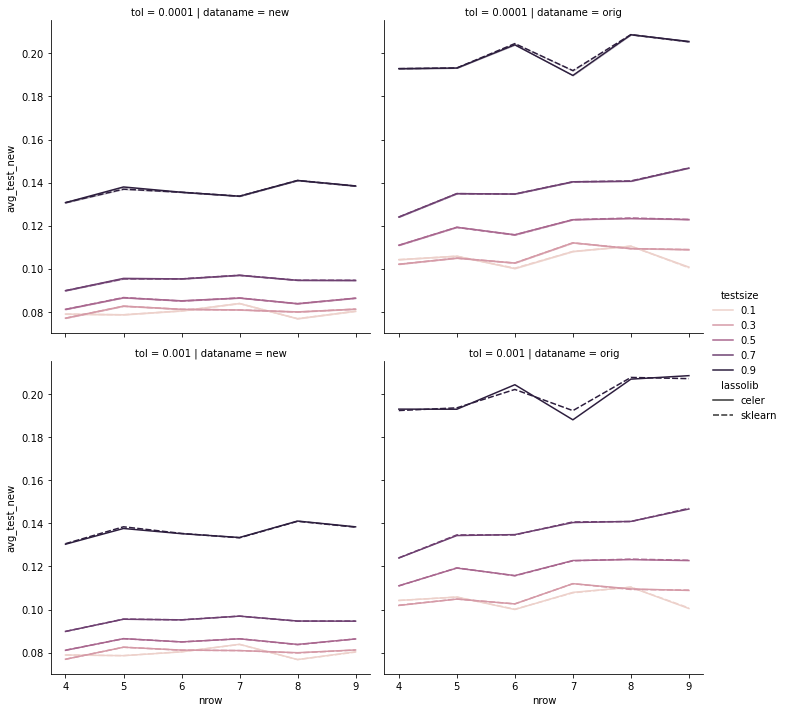

In [655]:
sns.relplot(
    data=dftemp, x='nrow', y='avg_test_new',
    col='dataname', row='tol', style='lassolib', hue='testsize',
    kind='line',
)

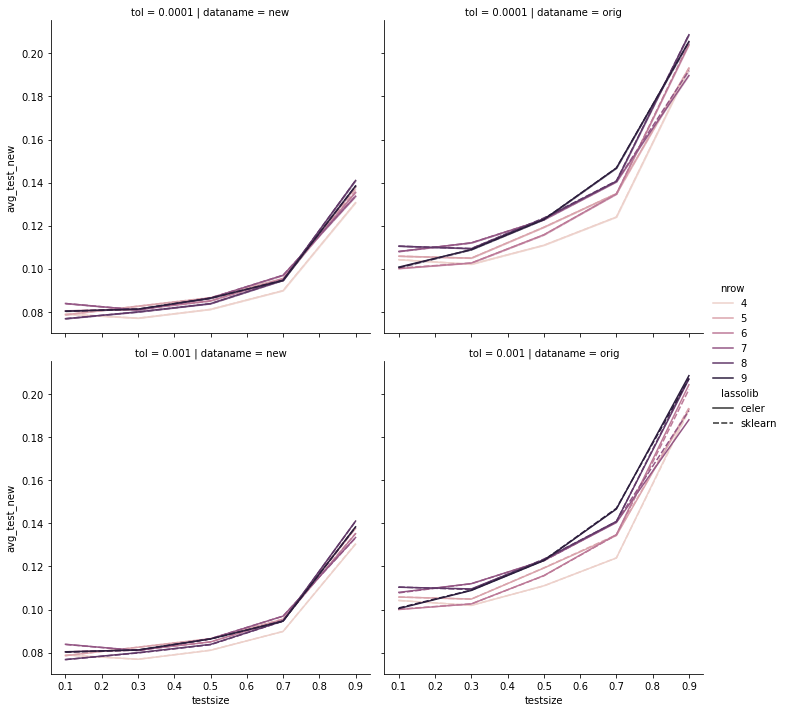

In [656]:
sns.relplot(
    data=dftemp, x='testsize', y='avg_test_new',
    col='dataname', row='tol', style='lassolib', hue='nrow',
    kind='line',
)

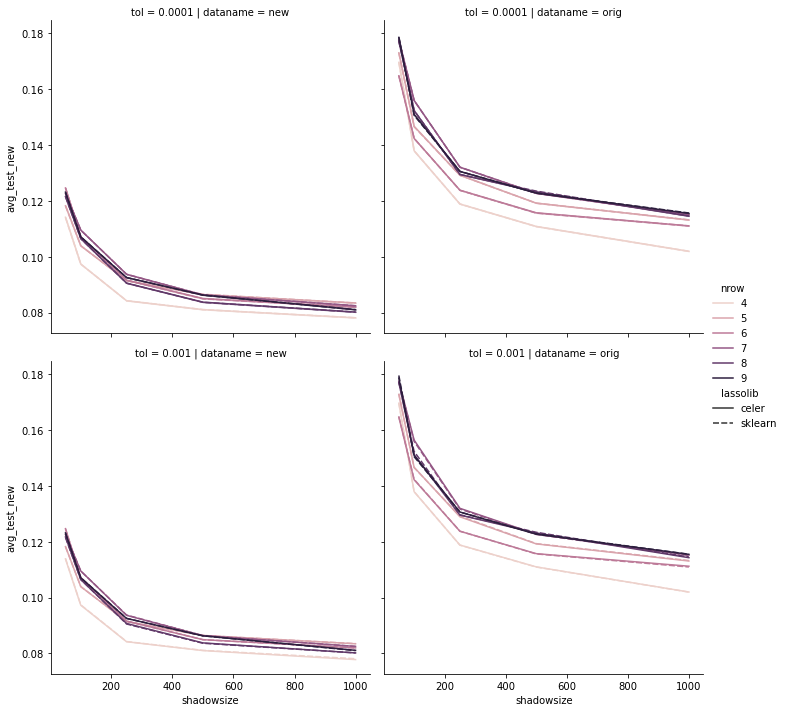

In [657]:
dftemp = df[(df['qubitdist']==1) & (df['testsize']==0.5) ]
sns.relplot(
    data=dftemp, x='shadowsize', y='avg_test_new',
    col='dataname', row='tol', style='lassolib', hue='nrow',
    kind='line',
)

# export df to excel

In [658]:
df = get_results('./clean_results300')

  0%|          | 0/10800 [00:00<?, ?it/s]

In [659]:
df.to_excel('./clean_results300/results_all.xlsx')

In [660]:
df = get_results('./clean_results500')

  0%|          | 0/6300 [00:00<?, ?it/s]

In [661]:
df.to_excel('./clean_results500/results_all.xlsx')

In [270]:
# df.columns

Index(['algo', 'algo_setting', 'dataname', 'dirinclx', 'dirsf', 'lassolib',
       'maxep', 'maxiter', 'ncol', 'nrow', 'ntknorm', 'path', 'qubitdist',
       'shadowsize', 'srvtol', 'testsize', 'tol', 'nedges', 'edges',
       'best_cv_score_dirichlet', 'test_score_dirichlet',
       'best_cv_score_gauss', 'test_score_gauss', 'best_cv_score_ntk2',
       'test_score_ntk2', 'best_cv_score_ntk3', 'test_score_ntk3',
       'best_cv_score_ntk4', 'test_score_ntk4', 'best_cv_score_ntk5',
       'test_score_ntk5', 'best_cv_score_new', 'test_score_new', 'nsamples',
       'avg_train_dirichlet', 'avg_train_gauss', 'avg_train_ntk2',
       'avg_train_ntk3', 'avg_train_ntk4', 'avg_train_ntk5', 'avg_train_new',
       'avg_test_orig', 'avg_train_orig'],
      dtype='object')

In [645]:
# savedf = df.copy()

In [646]:
# savedf.algo_setting.unique()

array(['orig_algorithm_svrtol=0.0001_ntk-norm=True_diri-inclx=True_diri-sf=4',
       'orig_algorithm_svrtol=0.001_ntk-norm=True_diri-inclx=True_diri-sf=6',
       'new_algorithm_celer_maxiter=10000_maxep=50000_tol=0.01',
       'orig_algorithm_svrtol=0.001_ntk-norm=True_diri-inclx=True_diri-sf=4',
       'orig_algorithm_svrtol=0.0001_ntk-norm=True_diri-inclx=False_diri-sf=5',
       'orig_algorithm_svrtol=0.001_ntk-norm=True_diri-inclx=False_diri-sf=5',
       'orig_algorithm_svrtol=0.0001_ntk-norm=True_diri-inclx=True_diri-sf=6'],
      dtype=object)

In [647]:
# selection = [
#     'new_algorithm_celer_maxiter=10000_maxep=50000_tol=0.01',
#     'orig_algorithm_svrtol=0.0001_ntk-norm=True_diri-inclx=True_diri-sf=4',
# ]
# savedf = savedf[savedf['algo_setting'].isin(selection)]

In [648]:
# savedf.columns

Index(['srvtol', 'ntknorm', 'dirinclx', 'dirsf', 'testsize', 'shadowsize',
       'qubitdist', 'nrow', 'ncol', 'dataname', 'path', 'algo', 'algo_setting',
       'lassolib', 'maxep', 'maxiter', 'tol', 'nedges', 'edges',
       'best_cv_score_dirichlet', 'test_score_dirichlet',
       'best_cv_score_gauss', 'test_score_gauss', 'best_cv_score_ntk2',
       'test_score_ntk2', 'best_cv_score_ntk3', 'test_score_ntk3',
       'best_cv_score_ntk4', 'test_score_ntk4', 'best_cv_score_ntk5',
       'test_score_ntk5', 'best_cv_score_new', 'test_score_new', 'nsamples',
       'avg_train_dirichlet', 'avg_test_dirichlet', 'avg_train_gauss',
       'avg_test_gauss', 'avg_train_ntk2', 'avg_test_ntk2', 'avg_train_ntk3',
       'avg_test_ntk3', 'avg_train_ntk4', 'avg_test_ntk4', 'avg_train_ntk5',
       'avg_test_ntk5', 'avg_train_new', 'avg_test_new', 'avg_test_orig',
       'avg_train_orig'],
      dtype='object')

In [649]:

# savedf = savedf.drop(columns=[c for c in savedf.columns if 'best' in c])
# savedf = savedf.drop(columns=[c for c in savedf.columns if 'test_score' in c])
# #savedf = savedf.drop(columns=[c for c in savedf.columns if 'avg_train' in c])

# todrop = ['edges', 'path',]
# for c in savedf.columns:
#     try:
#         if len(savedf[c].unique()) == 1:
#             todrop.append(c)
#     except:
#         continue
# savedf = savedf.drop(columns=todrop)


# savedf.to_excel('./clean_results300/results_all.xlsx')

In [610]:
# savedf.columns

Index(['srvtol', 'ntknorm', 'dirinclx', 'dirsf', 'testsize', 'shadowsize',
       'qubitdist', 'nrow', 'dataname', 'algo', 'algo_setting', 'lassolib',
       'maxep', 'maxiter', 'tol', 'nedges', 'nsamples', 'avg_train_dirichlet',
       'avg_test_dirichlet', 'avg_train_gauss', 'avg_test_gauss',
       'avg_train_ntk2', 'avg_test_ntk2', 'avg_train_ntk3', 'avg_test_ntk3',
       'avg_train_ntk4', 'avg_test_ntk4', 'avg_train_ntk5', 'avg_test_ntk5',
       'avg_train_new', 'avg_test_new', 'avg_test_orig', 'avg_train_orig'],
      dtype='object')

In [611]:
# len(savedf)

1800

# what effect does tol have?

## for original method
* best one is tol=1e-4 but 1e-3 ist basically equal
* use inclx=True and dirsf=4 


In [662]:
df = get_results('./clean_results300')
# df = get_results('./clean_results500')

  0%|          | 0/10800 [00:00<?, ?it/s]

In [663]:
df2 = df.copy()
df2 = df2[(df2['algo'] == 'orig') &\
          (df2['qubitdist']==1) &\
          (df2['dataname']=='new')]

# df2 = df2[(df2['algo'] == 'orig') &\
#           (df2['shadowsize']==500) &\
#           (df2['qubitdist']==1) &\
#           (df2['nrow'] == 4) &\
#           (df2['dataname']=='new')]
# df2 = df2[(df2['dirsf'] == 4) &\
#          (df2['testsize']==0.5)]
df2 = df2.drop(columns=[c for c in df2.columns if 'best' in c])
df2 = df2.drop(columns=[c for c in df2.columns if 'test_score' in c])
df2 = df2.drop(columns=[c for c in df2.columns if 'avg_train' in c])

todrop = ['edges', 'path', 'nedges']
for c in df2.columns:
    try:
        if len(df2[c].unique()) == 1:
            todrop.append(c)
    except:
        continue
df2 = df2.drop(columns=todrop)
#df2 = df2.drop(columns=['train_mat','test_mat', 'edges', 'best_cv_score', 'test_score'])

In [664]:
df2.algo_setting.unique()

array(['orig_algorithm_svrtol=0.0001_ntk-norm=True_diri-inclx=True_diri-sf=4',
       'orig_algorithm_svrtol=0.001_ntk-norm=True_diri-inclx=True_diri-sf=6',
       'orig_algorithm_svrtol=0.001_ntk-norm=True_diri-inclx=True_diri-sf=4',
       'orig_algorithm_svrtol=0.0001_ntk-norm=True_diri-inclx=False_diri-sf=5',
       'orig_algorithm_svrtol=0.001_ntk-norm=True_diri-inclx=False_diri-sf=5',
       'orig_algorithm_svrtol=0.0001_ntk-norm=True_diri-inclx=True_diri-sf=6'],
      dtype=object)

In [665]:
df2.columns

Index(['testsize', 'shadowsize', 'nrow', 'algo_setting', 'srvtol', 'dirinclx',
       'dirsf', 'nsamples', 'avg_test_dirichlet', 'avg_test_gauss',
       'avg_test_ntk2', 'avg_test_ntk3', 'avg_test_ntk4', 'avg_test_ntk5',
       'avg_test_orig'],
      dtype='object')

In [666]:
display(len(df2))
df2.head()


900

testsize  shadowsize  nrow  \
1800       0.9         100     4   
1802       0.9         100     8   
1803       0.9         100     9   
1805       0.9         100     5   
1807       0.9         100     7   

                                                              algo_setting  \
1800  orig_algorithm_svrtol=0.0001_ntk-norm=True_diri-inclx=True_diri-sf=4   
1802  orig_algorithm_svrtol=0.0001_ntk-norm=True_diri-inclx=True_diri-sf=4   
1803  orig_algorithm_svrtol=0.0001_ntk-norm=True_diri-inclx=True_diri-sf=4   
1805  orig_algorithm_svrtol=0.0001_ntk-norm=True_diri-inclx=True_diri-sf=4   
1807  orig_algorithm_svrtol=0.0001_ntk-norm=True_diri-inclx=True_diri-sf=4   

      srvtol dirinclx  dirsf  nsamples  avg_test_dirichlet  avg_test_gauss  \
1800  0.0001     True    4.0     450.0            0.201707        0.182054   
1802  0.0001     True    4.0     450.0            0.200050        0.189022   
1803  0.0001     True    4.0     450.0            0.195824        0.186331   
1805  0.0001     True    4.0     450.0            0.206988        0.190052   
1807  0.0001     True    4.0     450.0            0.198850        0.187516   

      avg_test_ntk2  avg_test_ntk3  avg_test_ntk4  avg_test_ntk5  \
1800       0.199235       0.199155       0.199150       0.199192   
1802       0.197307       0.197275       0.197255       0.197204   
1803       0.192449       0.192415       0.192383       0.192396   
1805       0.202667       0.202615       0.202605       0.202632   
1807       0.195890       0.195841       0.195820       0.195820   

      avg_test_orig  
1800       0.182054  
1802       0.189022  
1803       0.186331  
1805       0.190052  
1807       0.187516

In [587]:
df3 = pd.wide_to_long(df2, stubnames=['avg_test_'], i=['algo_setting', 'srvtol','dirinclx','dirsf','nrow','shadowsize','testsize','nsamples', ], j='method', suffix=".+")
df3 = df3.rename({'avg_test_':'avg_test'}, axis=1)



In [588]:
display(df3.columns, len(df3))
df3.head(10)

Index(['avg_test'], dtype='object')

6300

avg_test
algo_setting                                                         srvtol dirinclx dirsf nrow shadowsize testsize nsamples method             
orig_algorithm_svrtol=0.0001_ntk-norm=True_diri-inclx=True_diri-sf=4 0.0001 True     4.0   4    100        0.9      450.0    dirichlet  0.195974
                                                                                                                             gauss      0.162139
                                                                                                                             ntk2       0.193835
                                                                                                                             ntk3       0.193801
                                                                                                                             ntk4       0.193900
                                                                                                                             ntk5       0.194075
                                                                                                                             orig       0.162139
                                                                                           8    100        0.9      450.0    dirichlet  0.198514
                                                                                                                             gauss      0.178633
                                                                                                                             ntk2       0.194364

In [589]:
df3 = df3.reset_index()
df3.head(10)

algo_setting  \
0  orig_algorithm_svrtol=0.0001_ntk-norm=True_diri-inclx=True_diri-sf=4   
1  orig_algorithm_svrtol=0.0001_ntk-norm=True_diri-inclx=True_diri-sf=4   
2  orig_algorithm_svrtol=0.0001_ntk-norm=True_diri-inclx=True_diri-sf=4   
3  orig_algorithm_svrtol=0.0001_ntk-norm=True_diri-inclx=True_diri-sf=4   
4  orig_algorithm_svrtol=0.0001_ntk-norm=True_diri-inclx=True_diri-sf=4   
5  orig_algorithm_svrtol=0.0001_ntk-norm=True_diri-inclx=True_diri-sf=4   
6  orig_algorithm_svrtol=0.0001_ntk-norm=True_diri-inclx=True_diri-sf=4   
7  orig_algorithm_svrtol=0.0001_ntk-norm=True_diri-inclx=True_diri-sf=4   
8  orig_algorithm_svrtol=0.0001_ntk-norm=True_diri-inclx=True_diri-sf=4   
9  orig_algorithm_svrtol=0.0001_ntk-norm=True_diri-inclx=True_diri-sf=4   

   srvtol dirinclx  dirsf  nrow  shadowsize  testsize  nsamples     method  \
0  0.0001     True    4.0     4         100       0.9     450.0  dirichlet   
1  0.0001     True    4.0     4         100       0.9     450.0      gauss   
2  0.0001     True    4.0     4         100       0.9     450.0       ntk2   
3  0.0001     True    4.0     4         100       0.9     450.0       ntk3   
4  0.0001     True    4.0     4         100       0.9     450.0       ntk4   
5  0.0001     True    4.0     4         100       0.9     450.0       ntk5   
6  0.0001     True    4.0     4         100       0.9     450.0       orig   
7  0.0001     True    4.0     8         100       0.9     450.0  dirichlet   
8  0.0001     True    4.0     8         100       0.9     450.0      gauss   
9  0.0001     True    4.0     8         100       0.9     450.0       ntk2   

   avg_test  
0  0.195974  
1  0.162139  
2  0.193835  
3  0.193801  
4  0.193900  
5  0.194075  
6  0.162139  
7  0.198514  
8  0.178633  
9  0.194364

In [590]:
plt.close("all")

/tmp/ipykernel_3296073/2337435939.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


<Figure size 432x288 with 0 Axes>

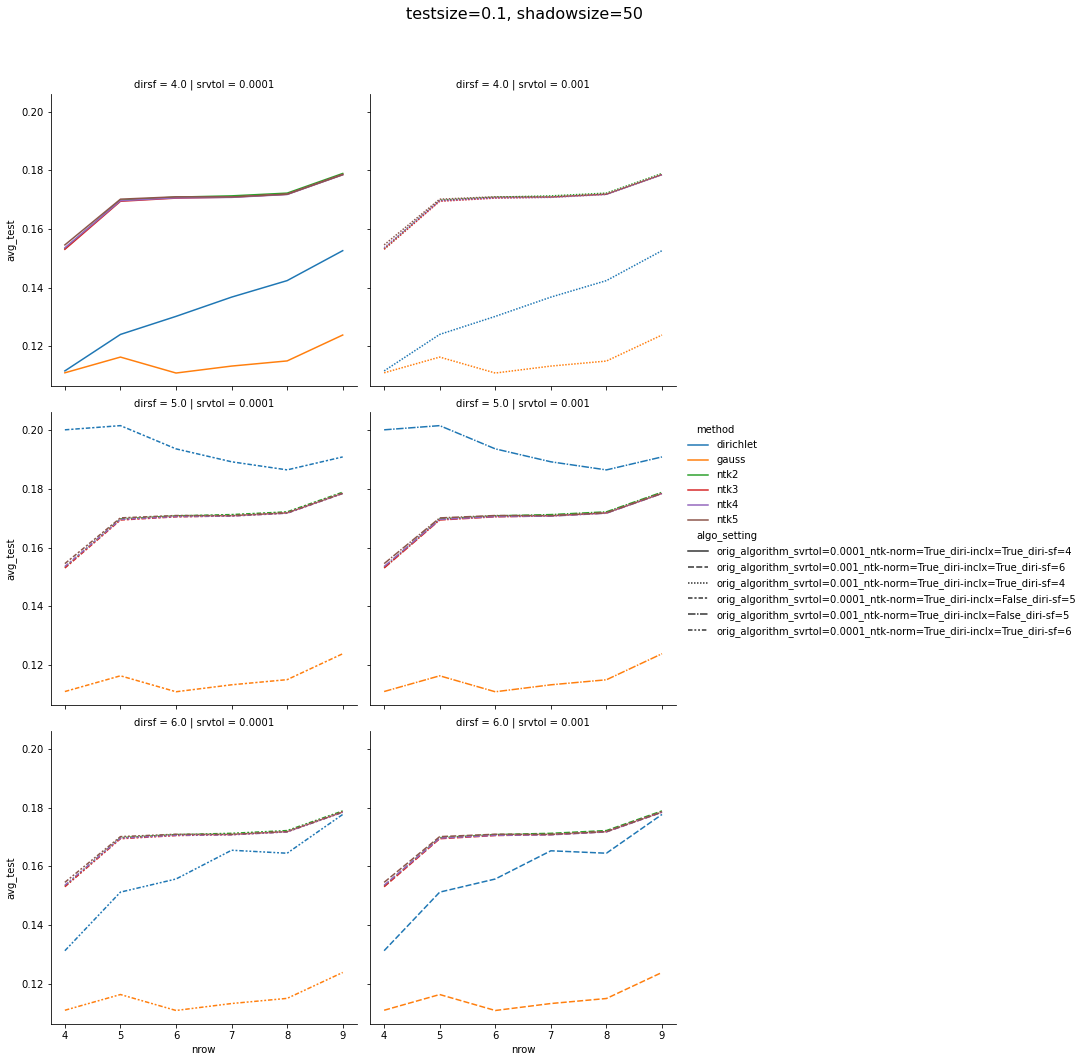

<Figure size 432x288 with 0 Axes>

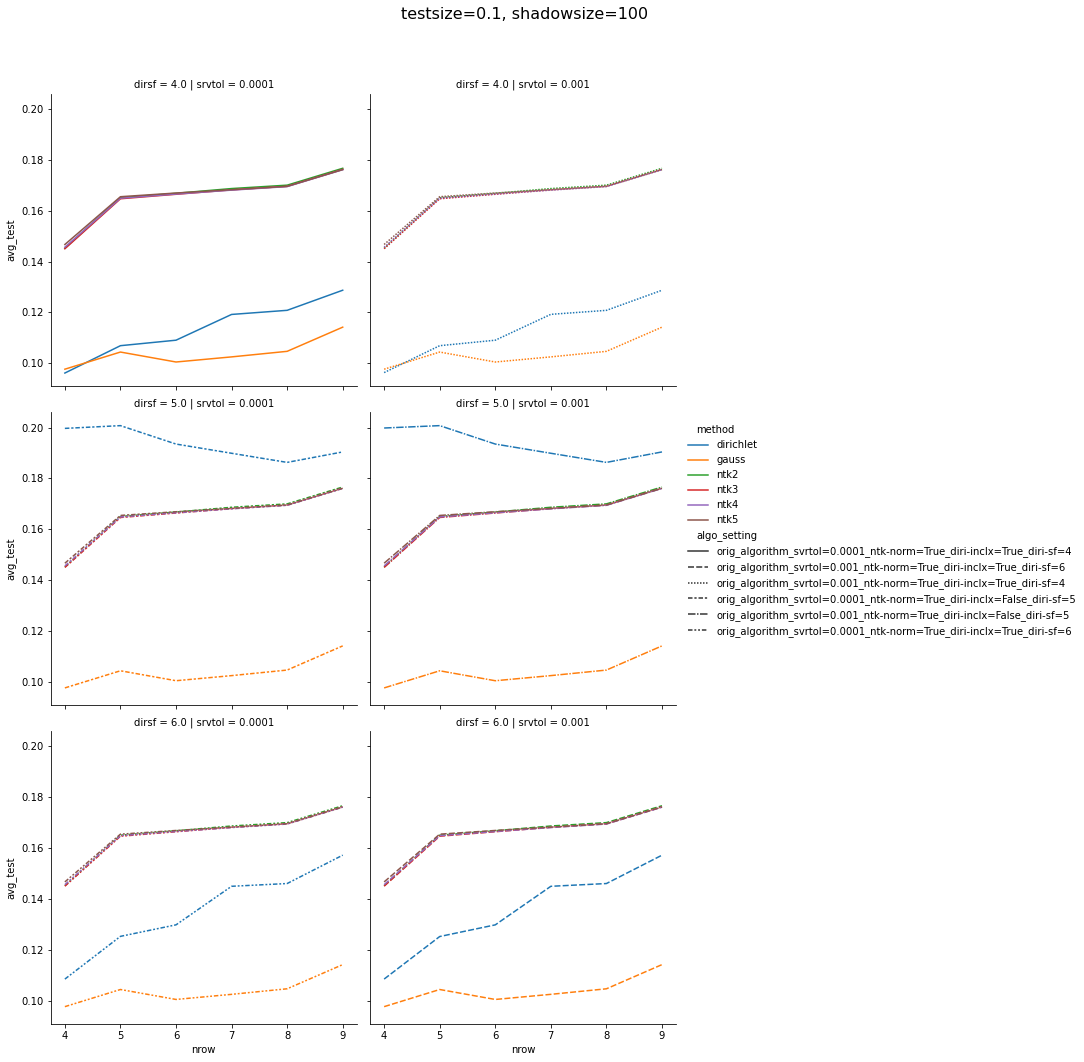

<Figure size 432x288 with 0 Axes>

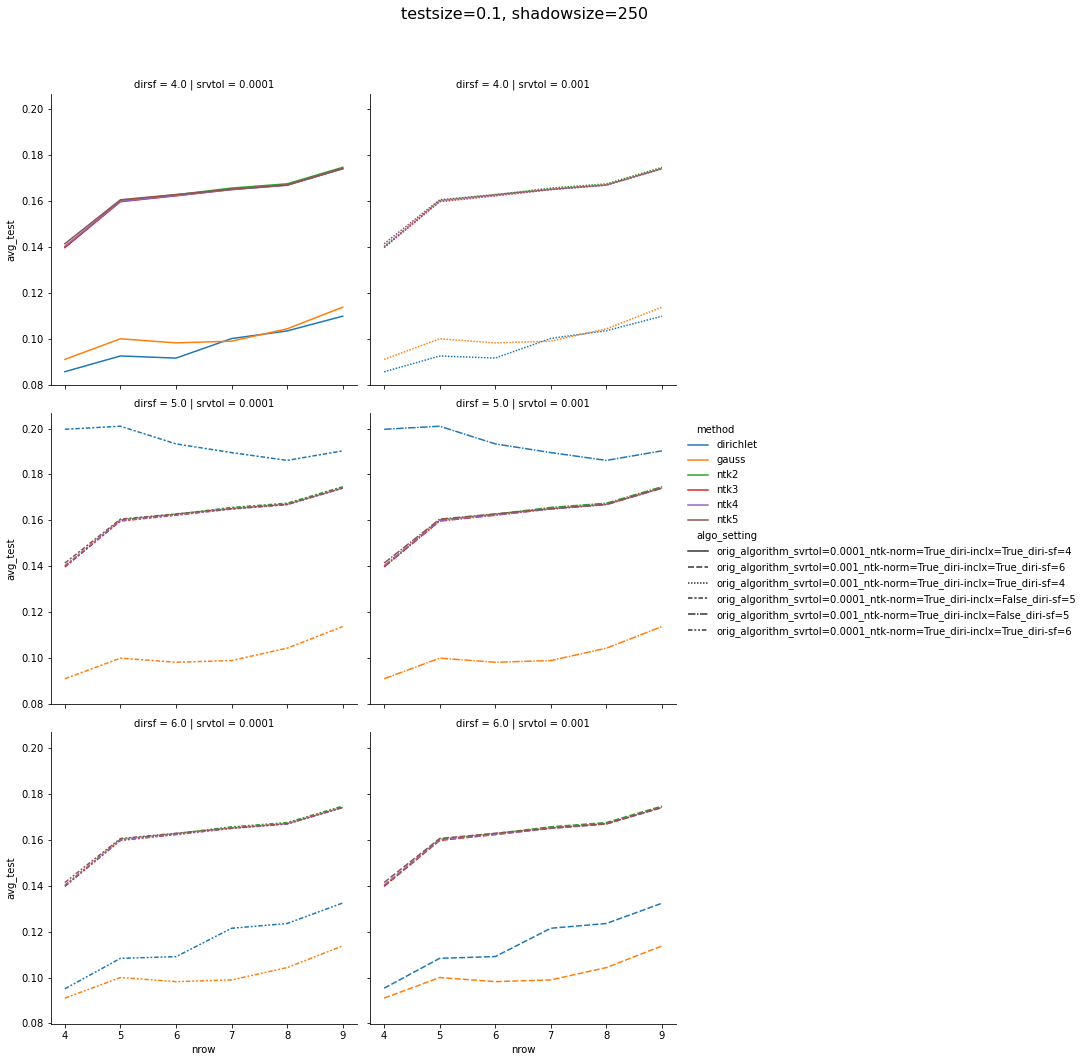

<Figure size 432x288 with 0 Axes>

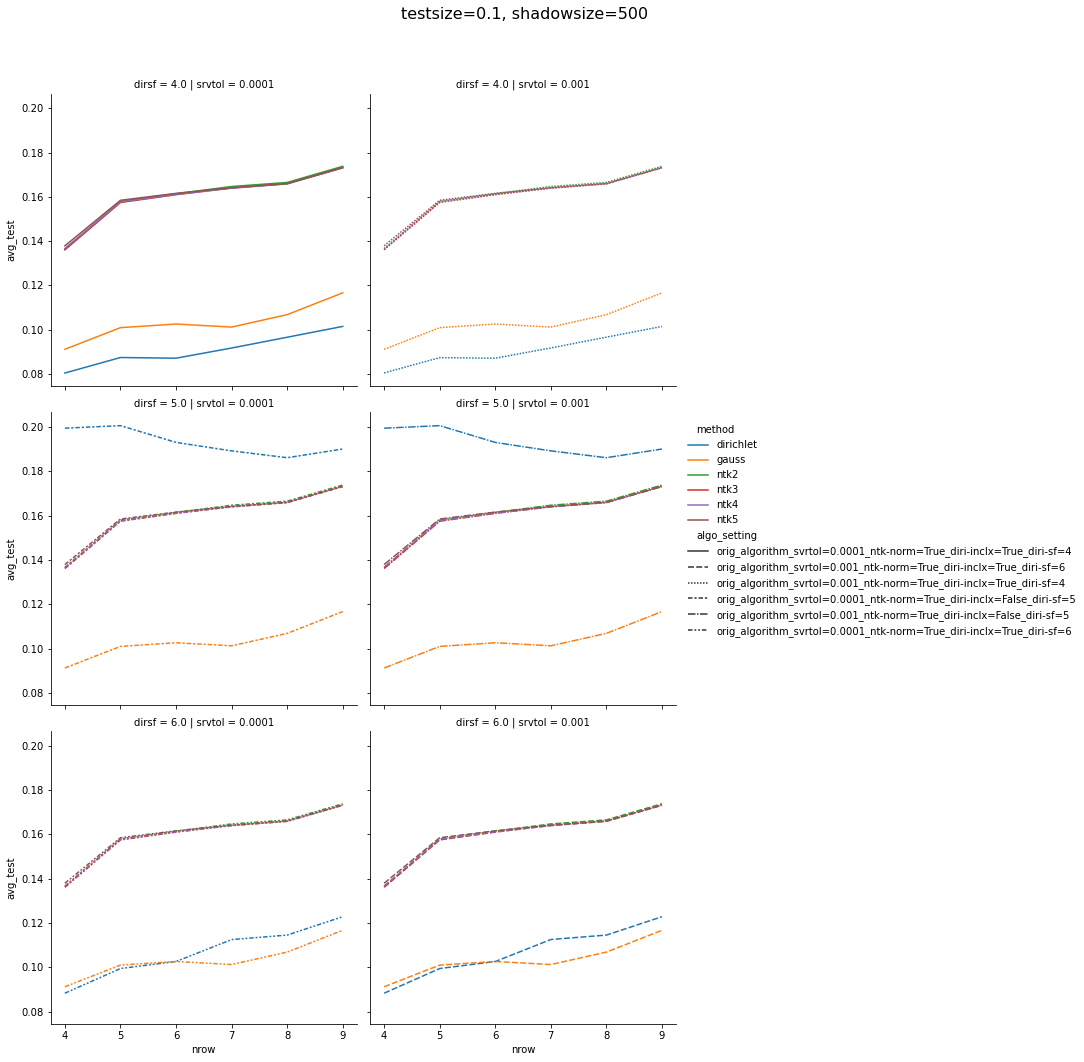

<Figure size 432x288 with 0 Axes>

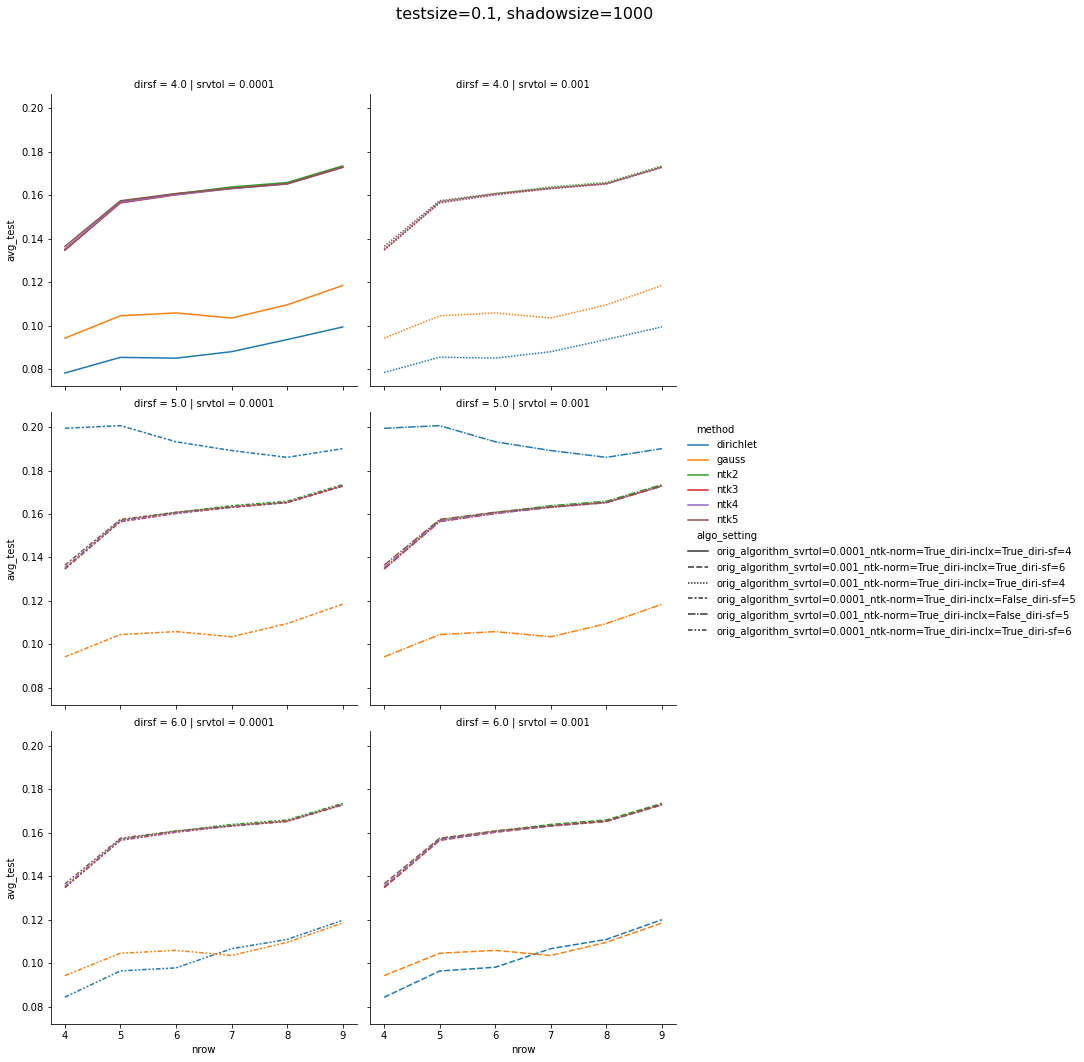

<Figure size 432x288 with 0 Axes>

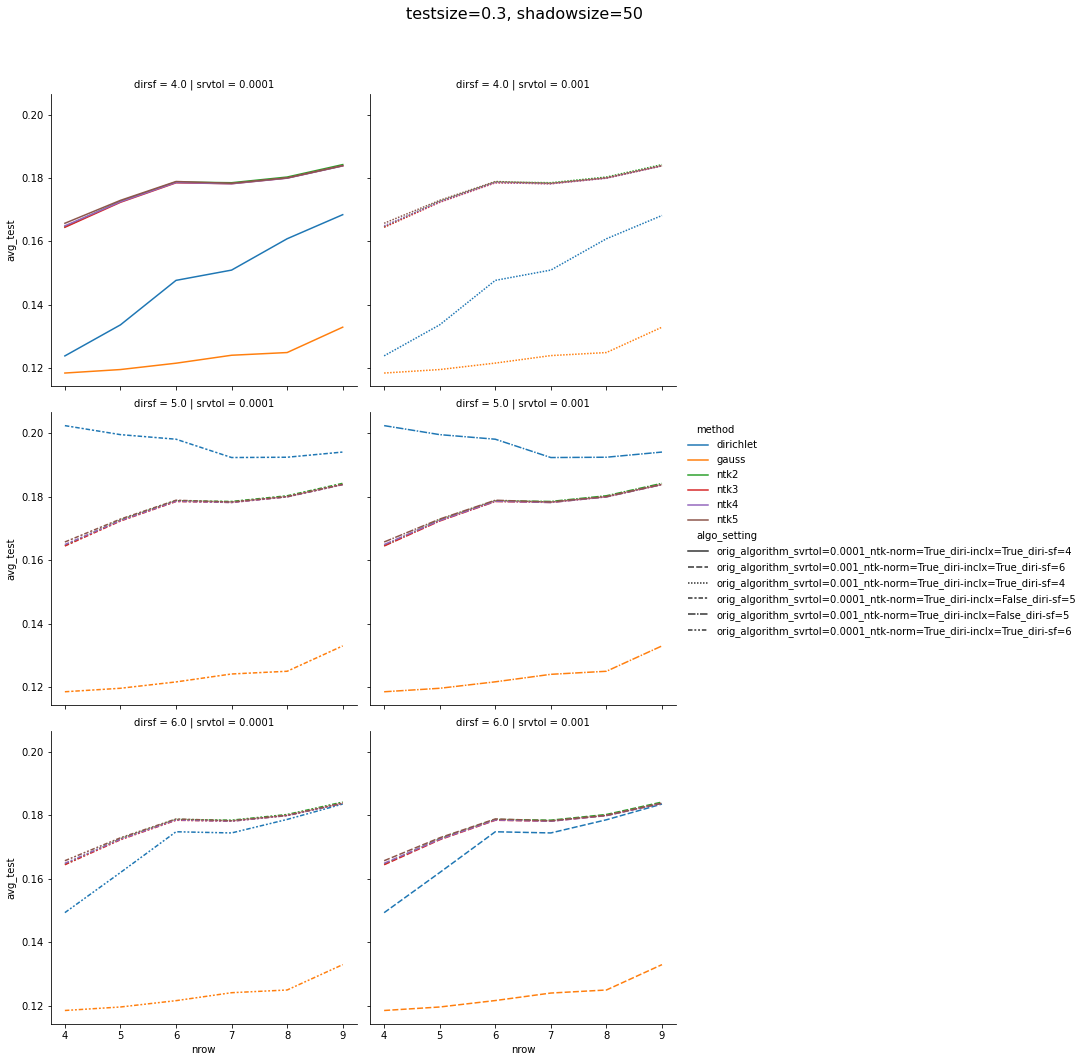

<Figure size 432x288 with 0 Axes>

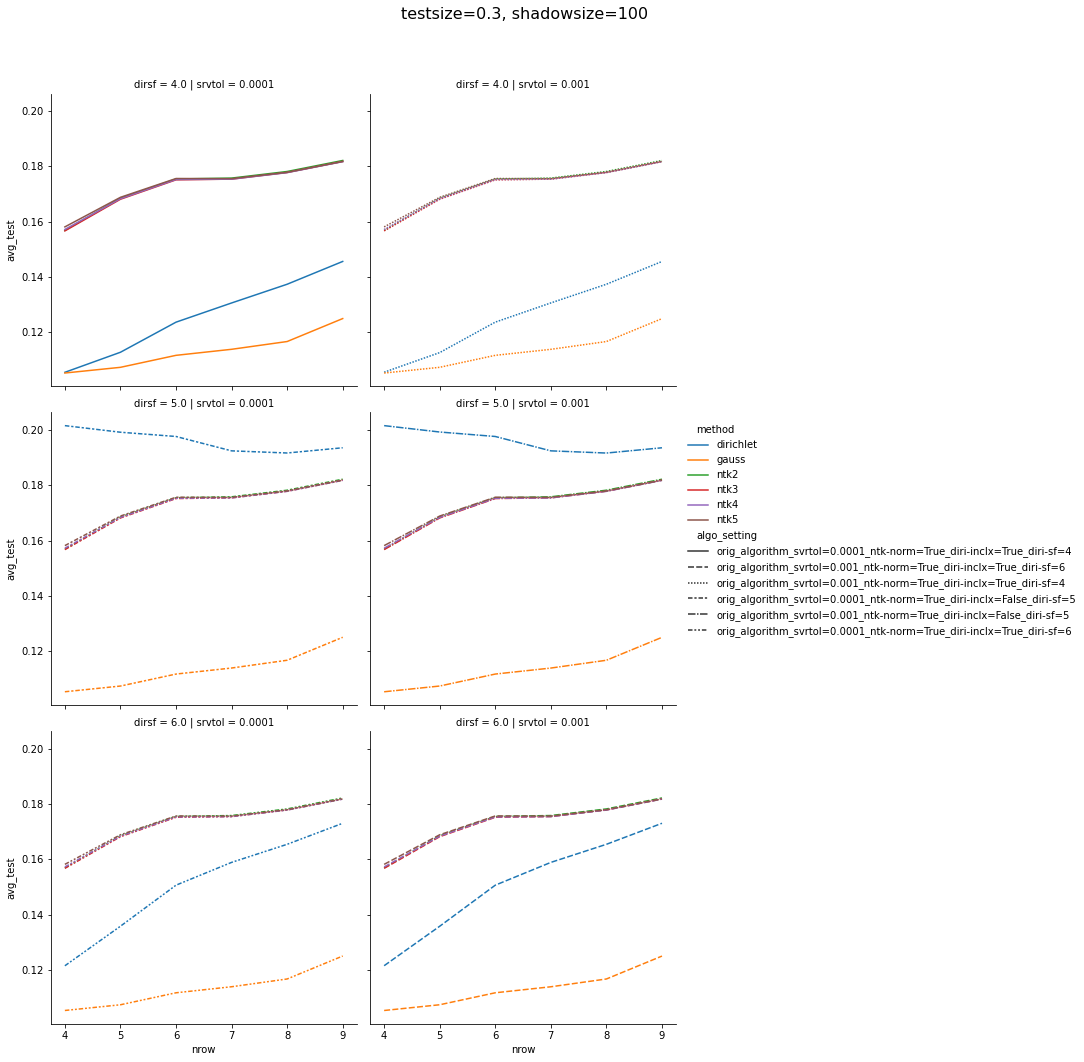

<Figure size 432x288 with 0 Axes>

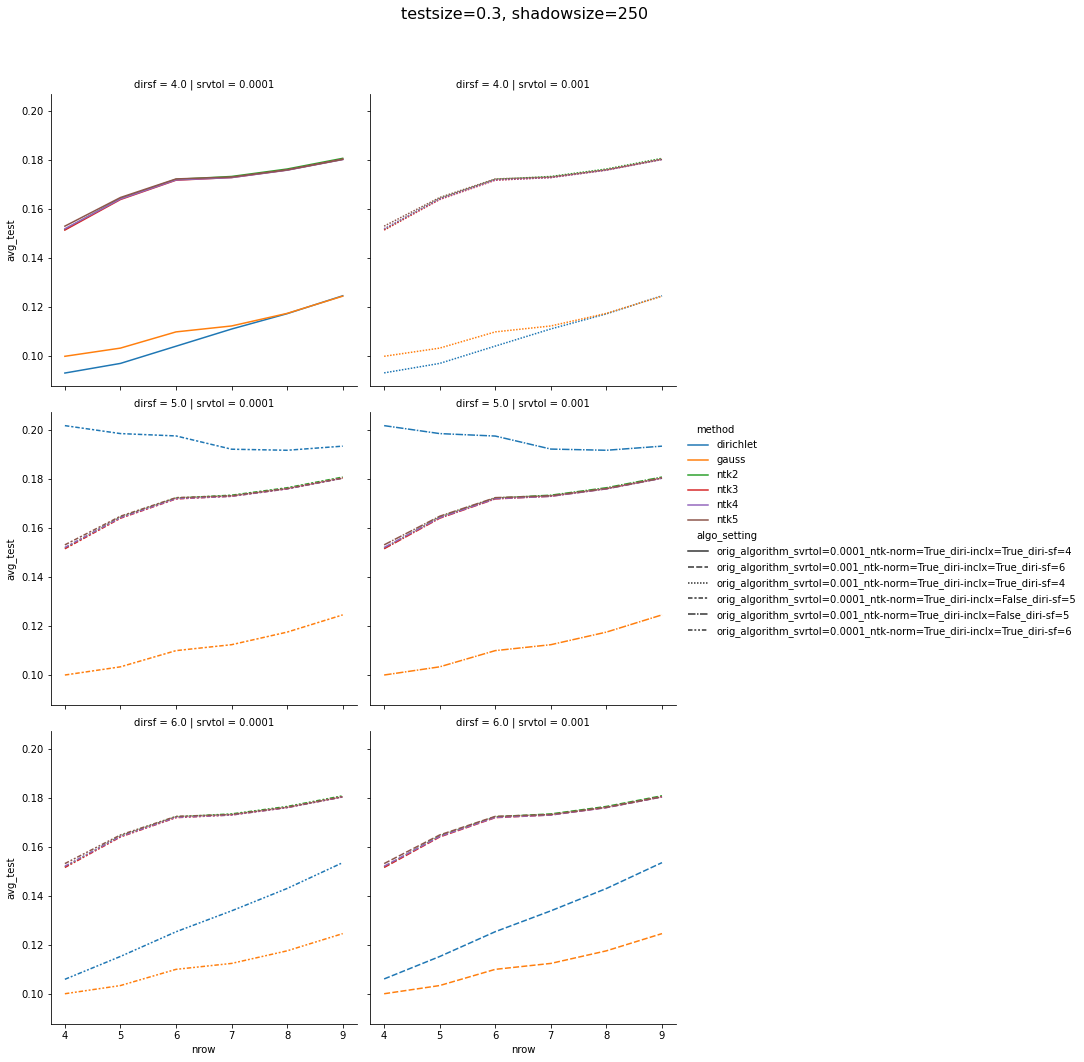

<Figure size 432x288 with 0 Axes>

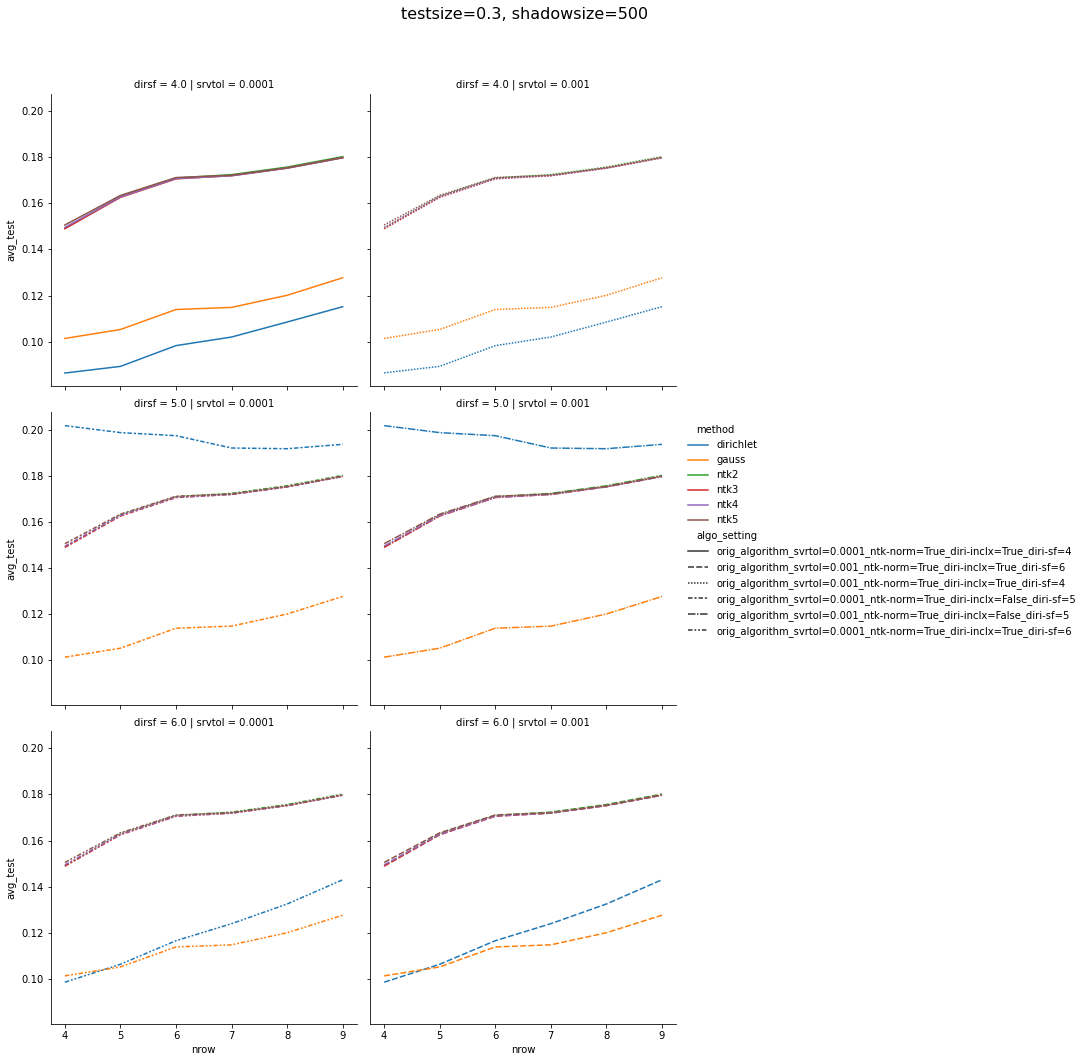

<Figure size 432x288 with 0 Axes>

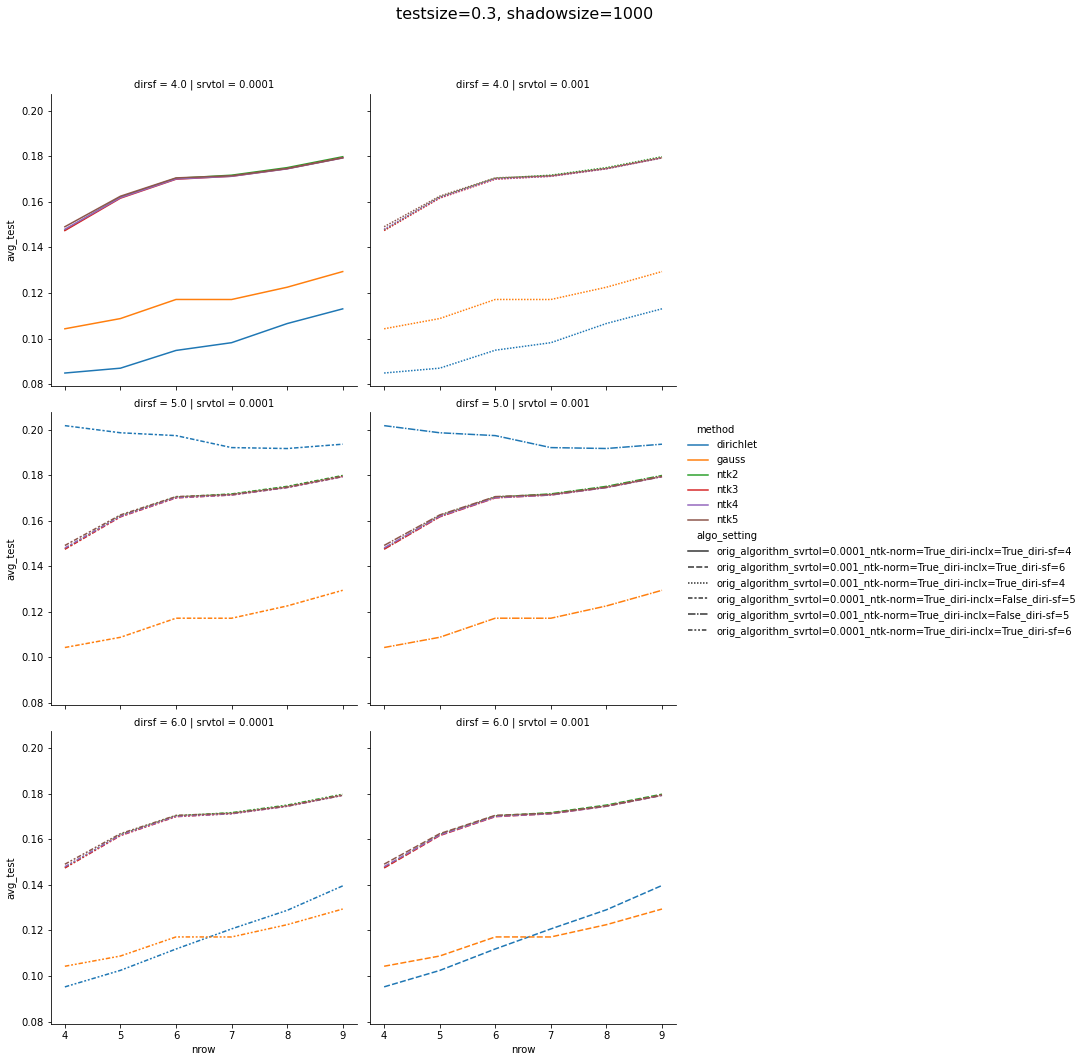

<Figure size 432x288 with 0 Axes>

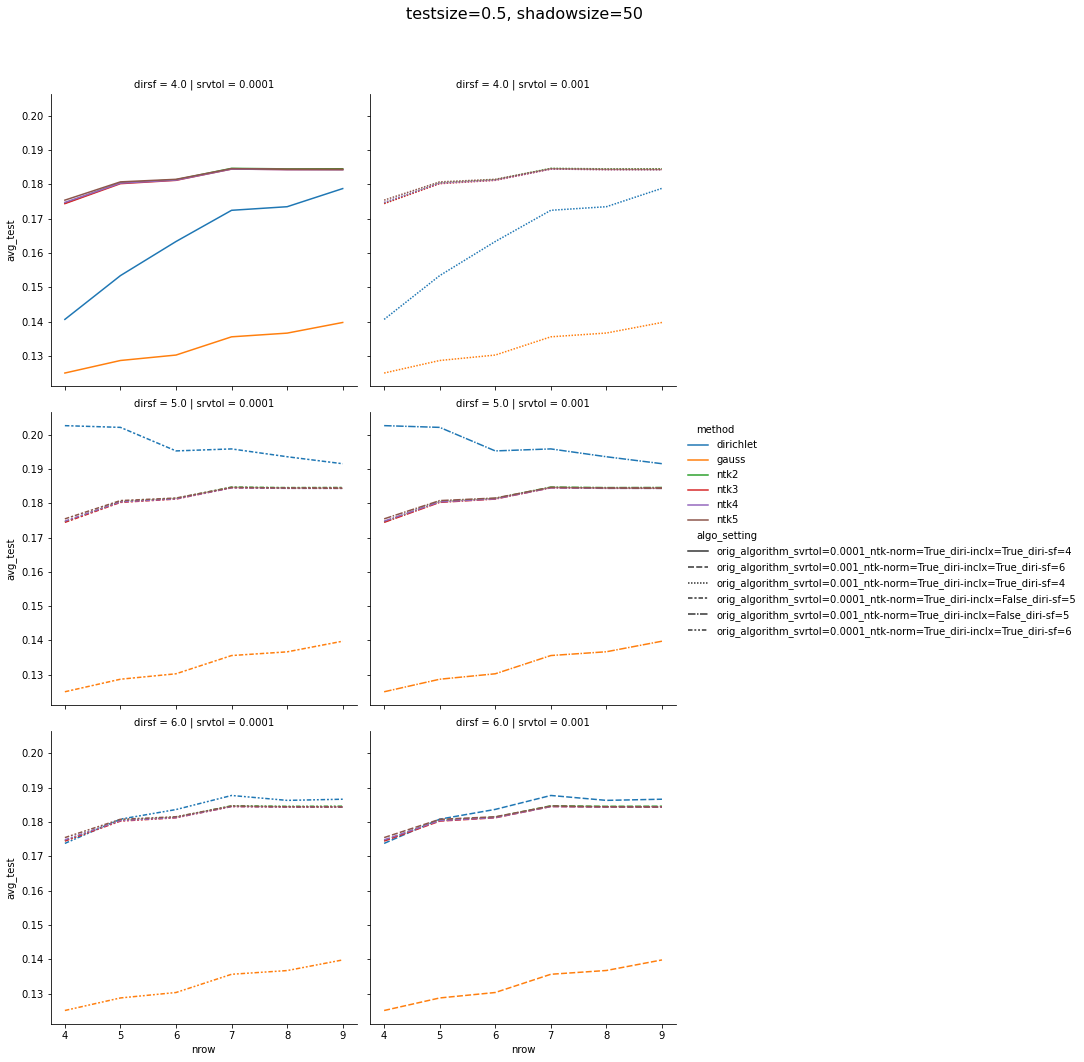

<Figure size 432x288 with 0 Axes>

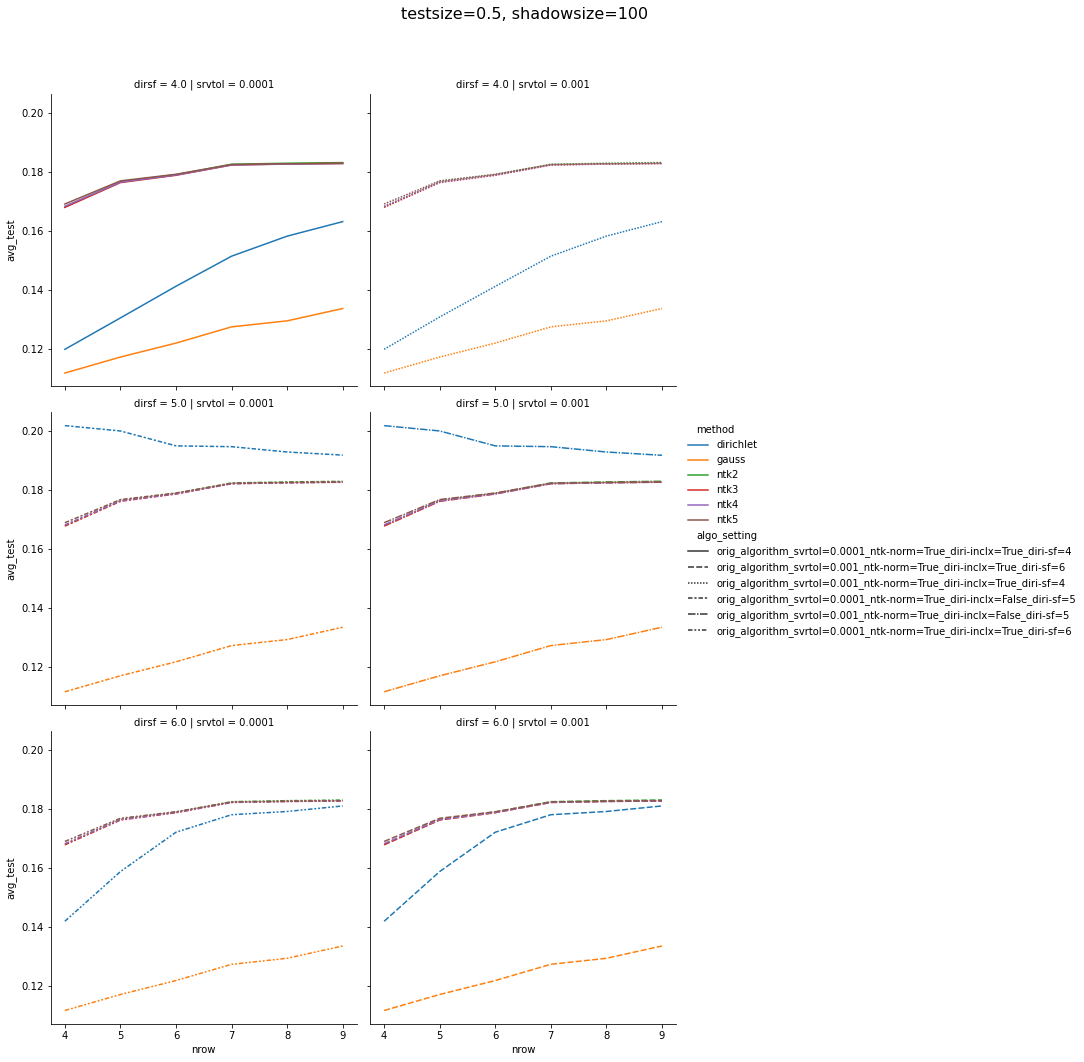

<Figure size 432x288 with 0 Axes>

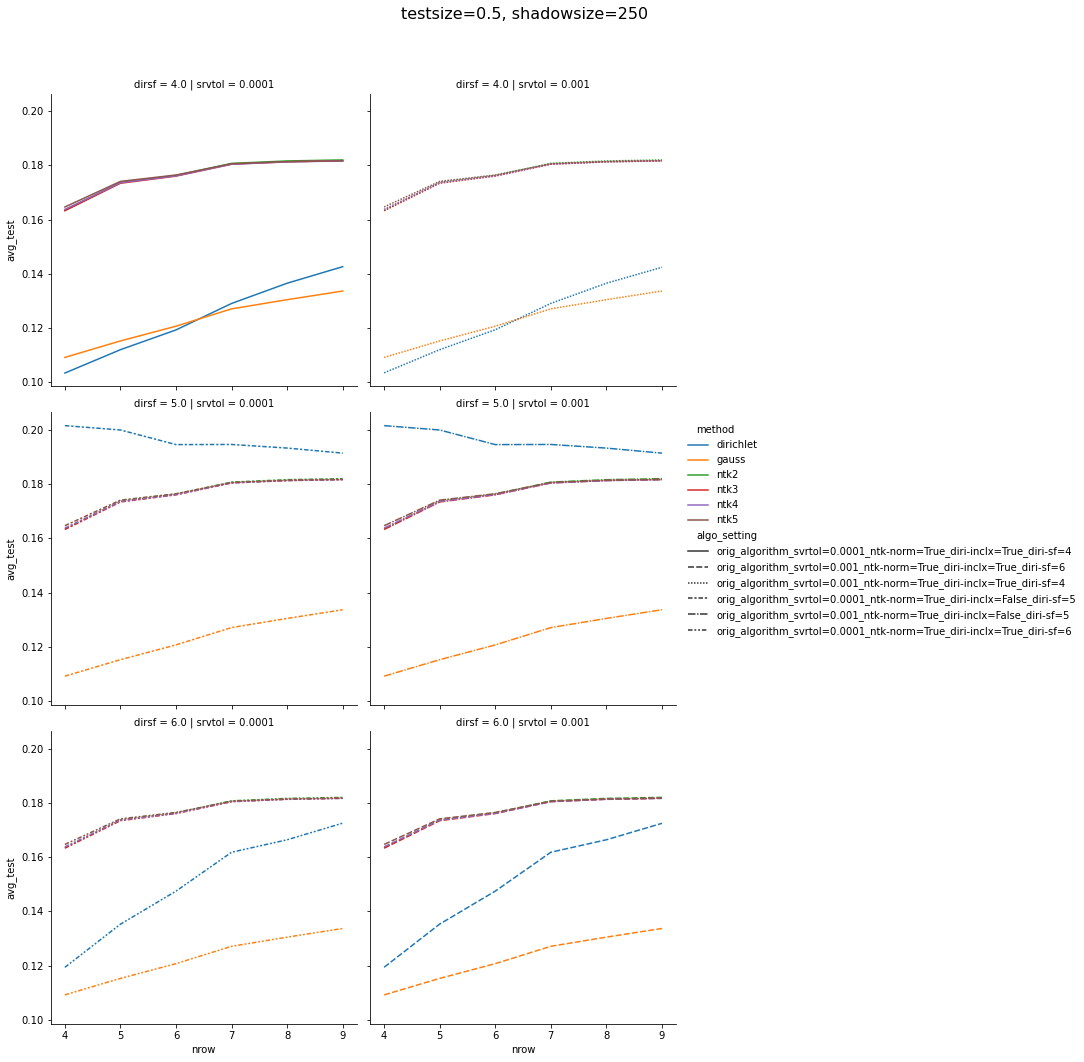

<Figure size 432x288 with 0 Axes>

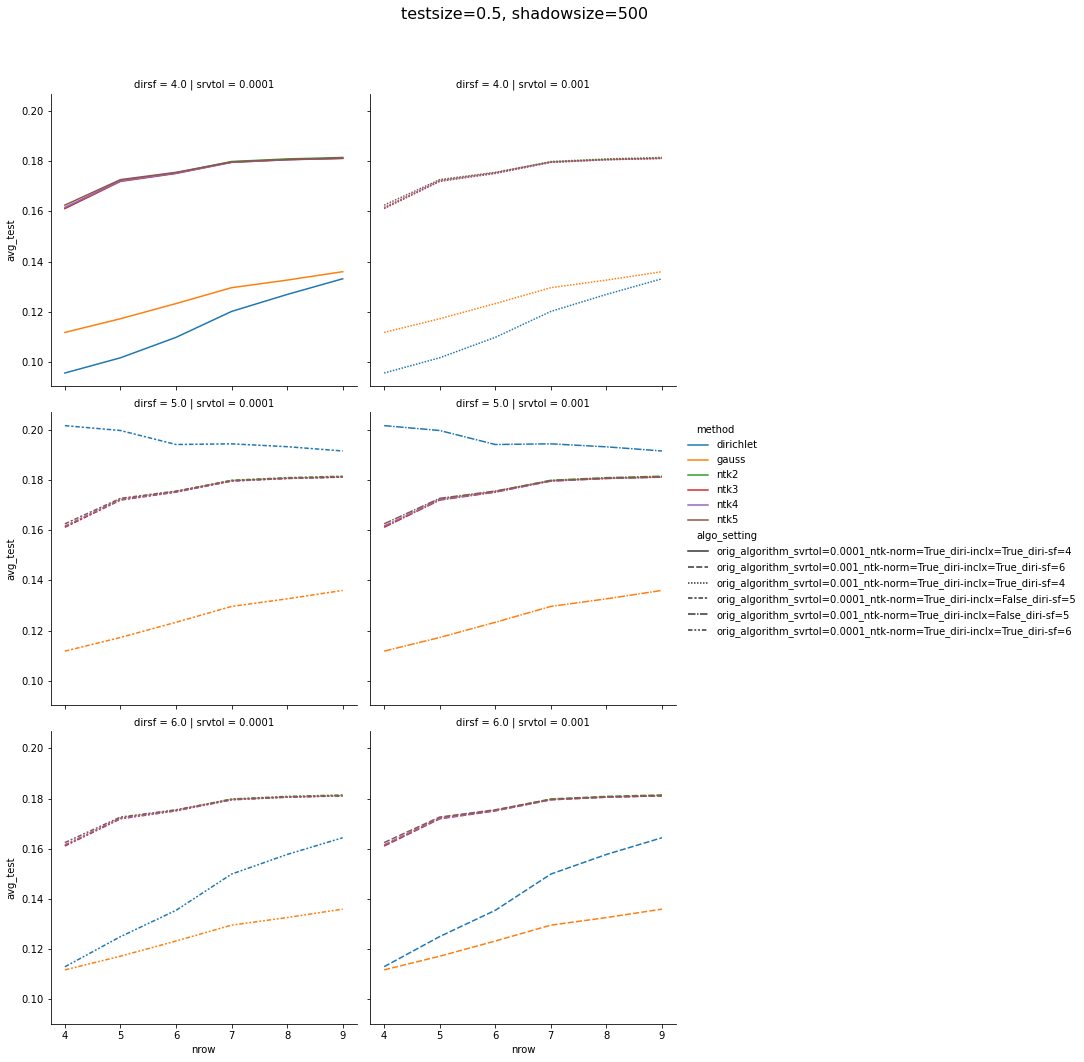

<Figure size 432x288 with 0 Axes>

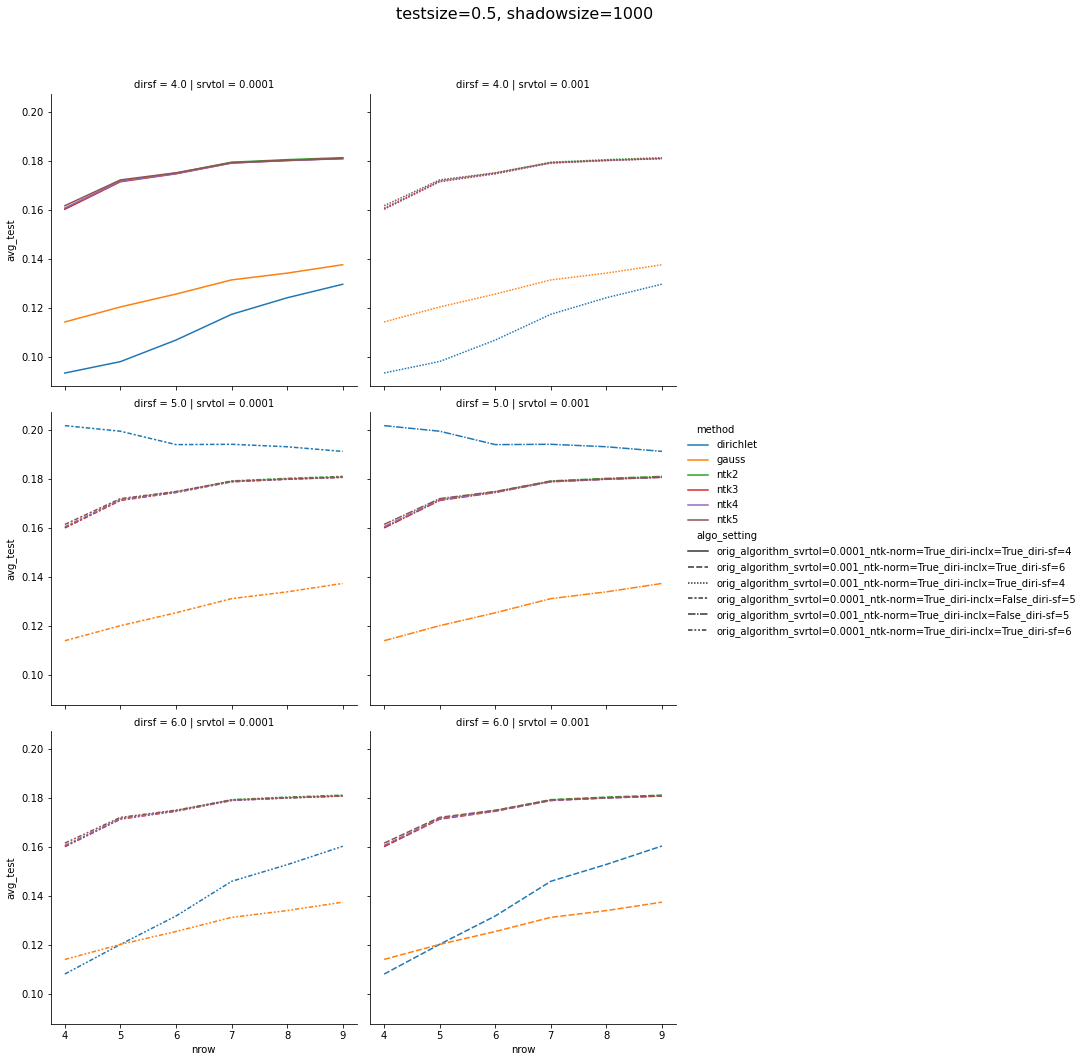

<Figure size 432x288 with 0 Axes>

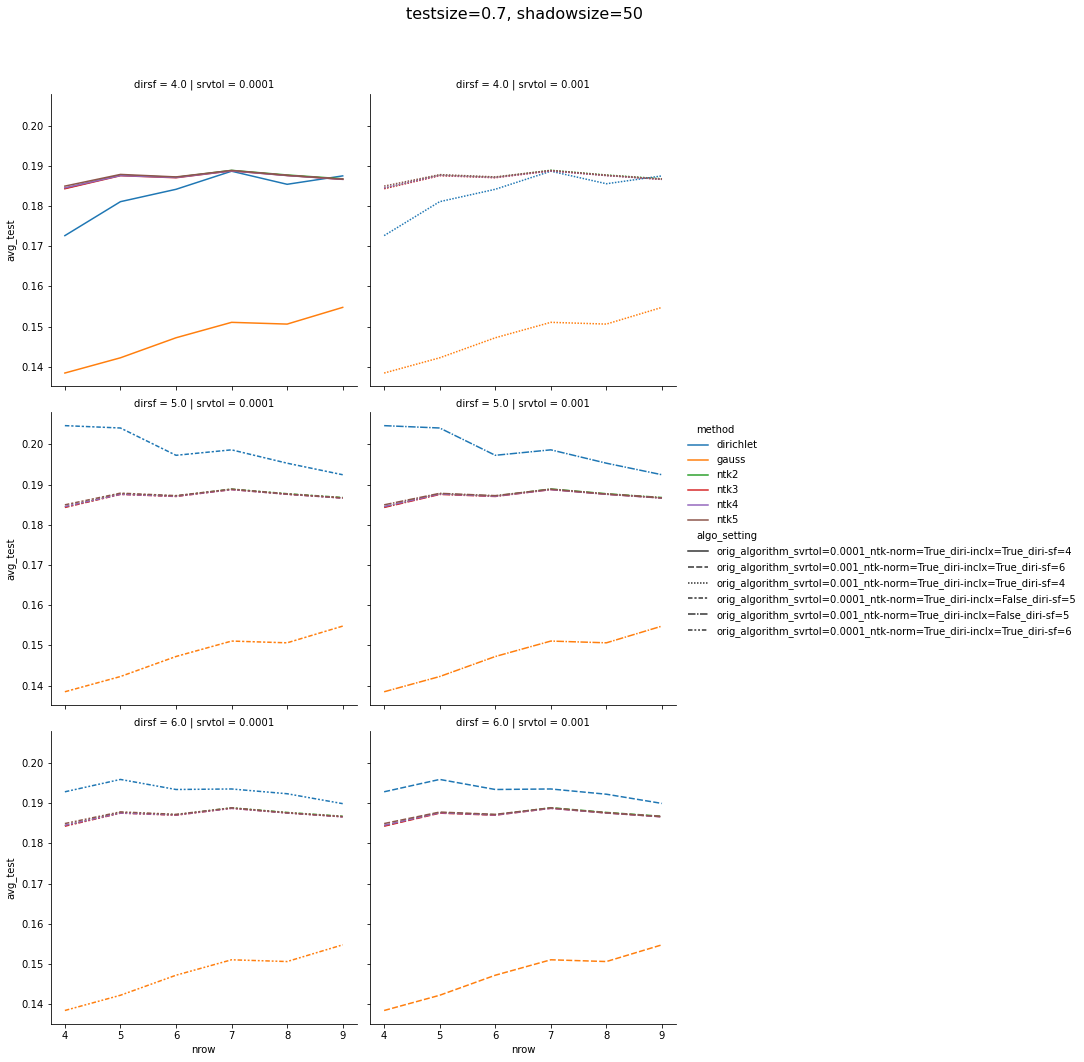

<Figure size 432x288 with 0 Axes>

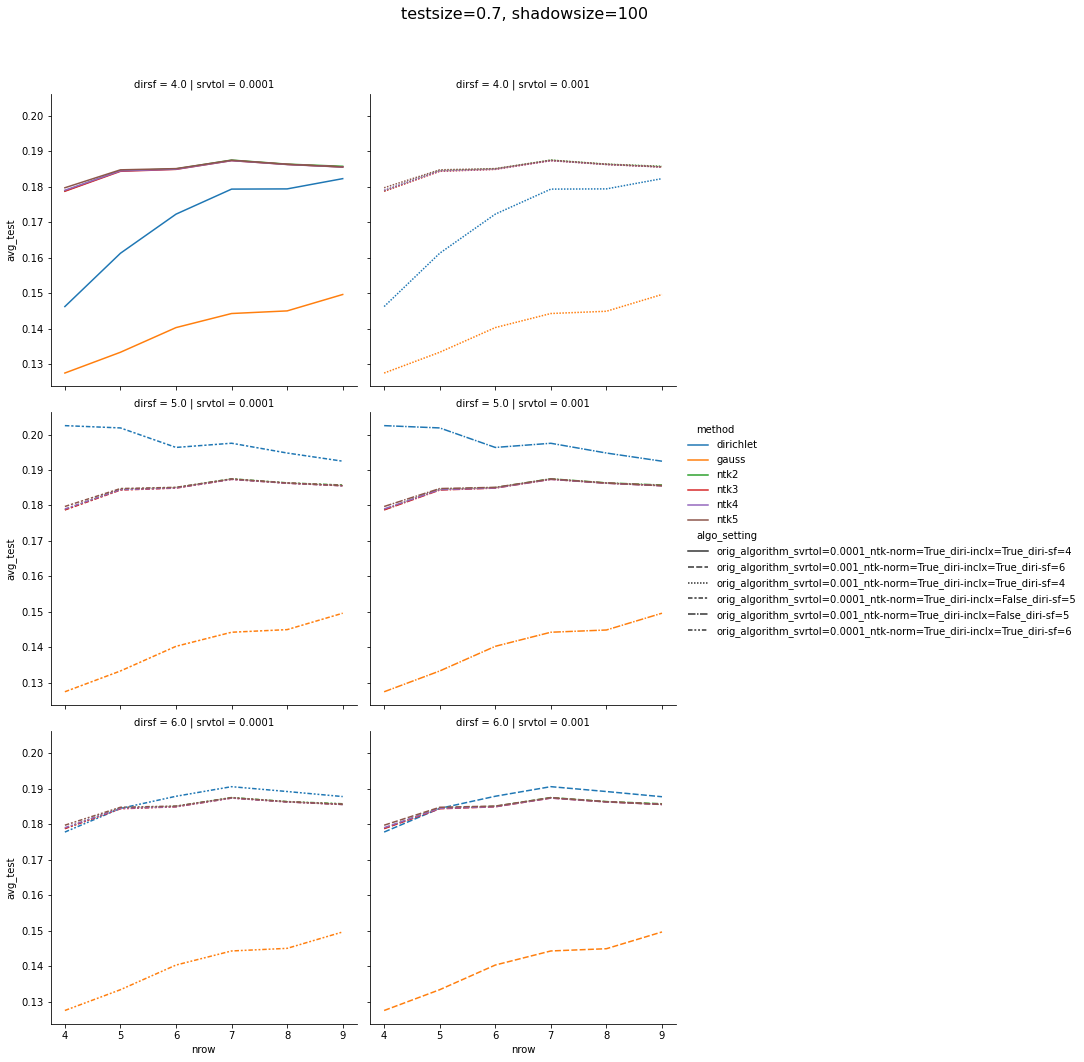

<Figure size 432x288 with 0 Axes>

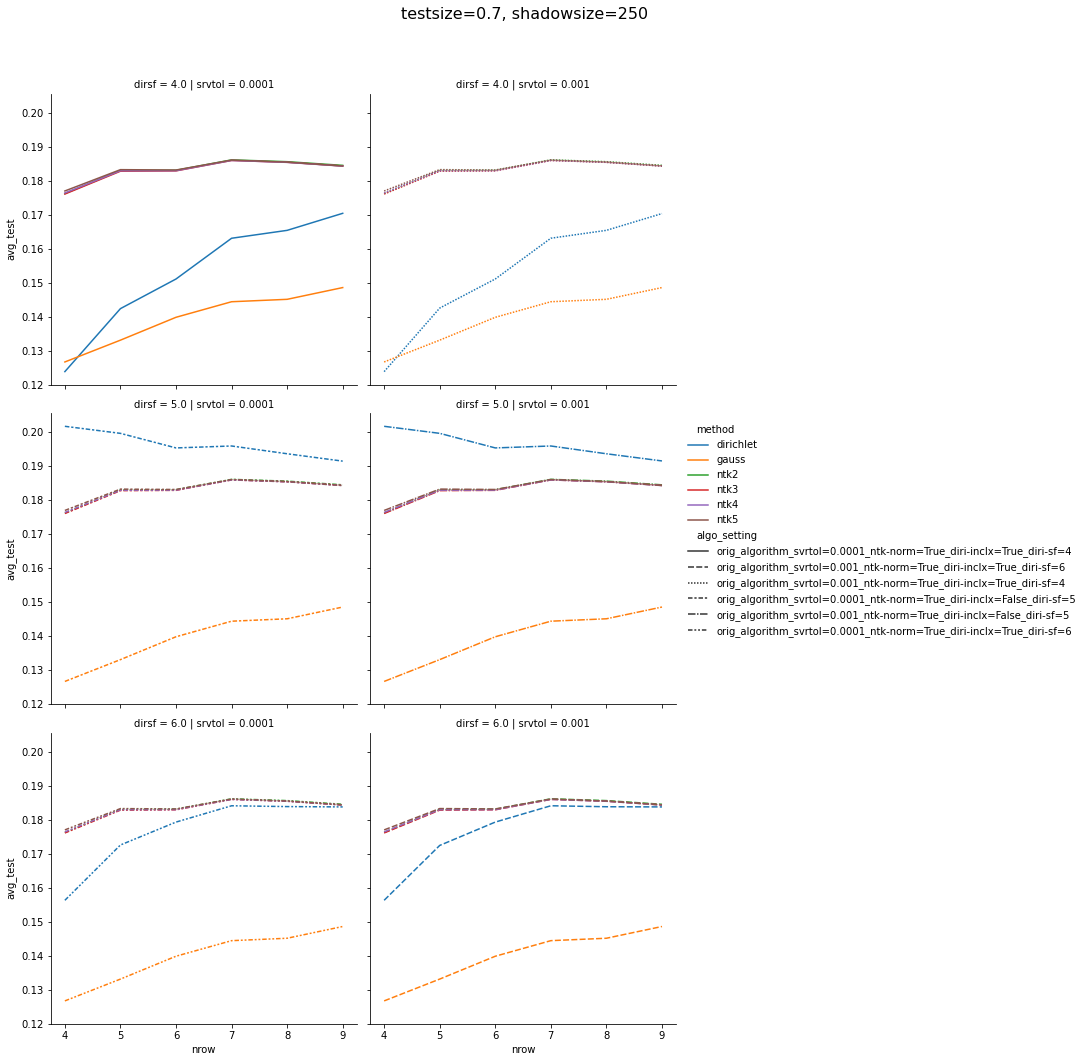

<Figure size 432x288 with 0 Axes>

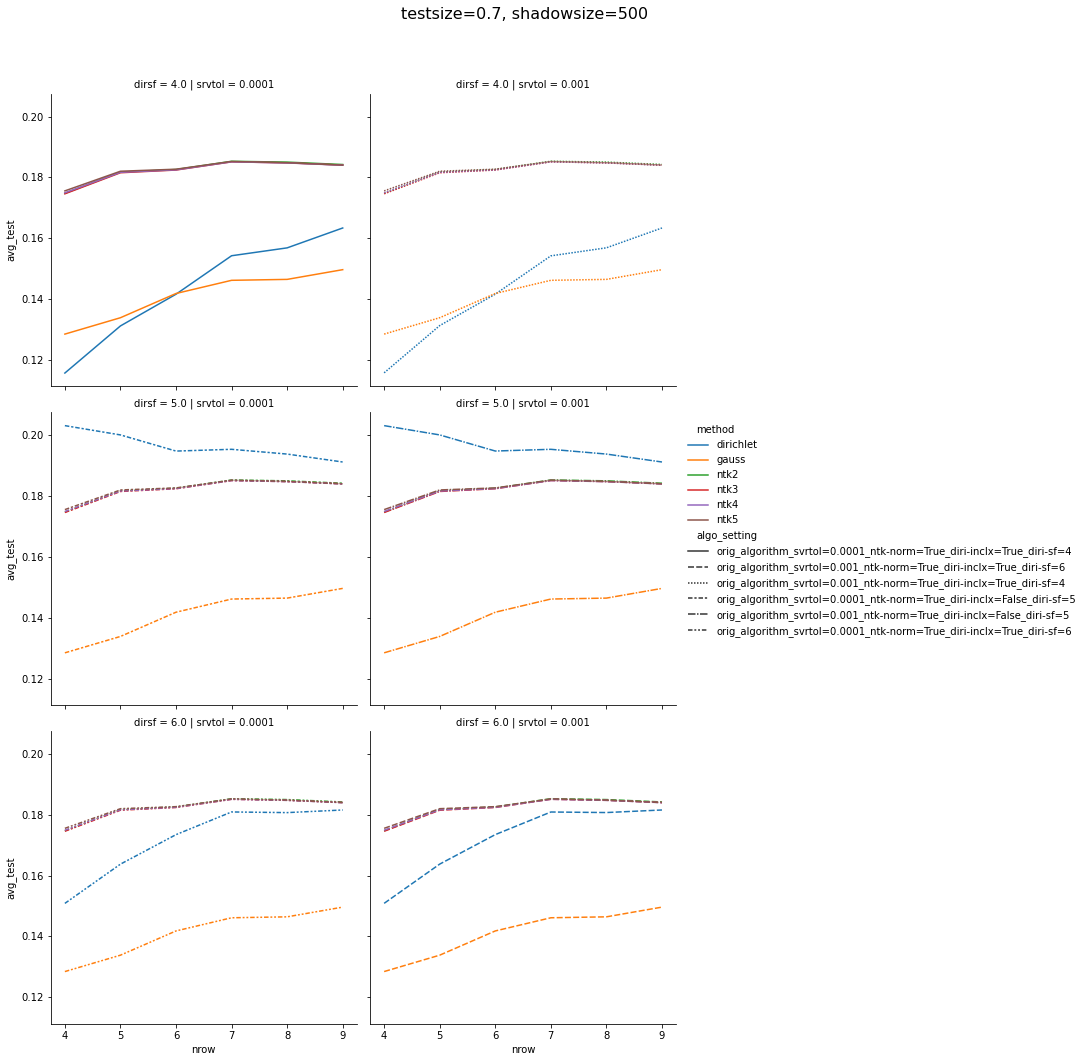

<Figure size 432x288 with 0 Axes>

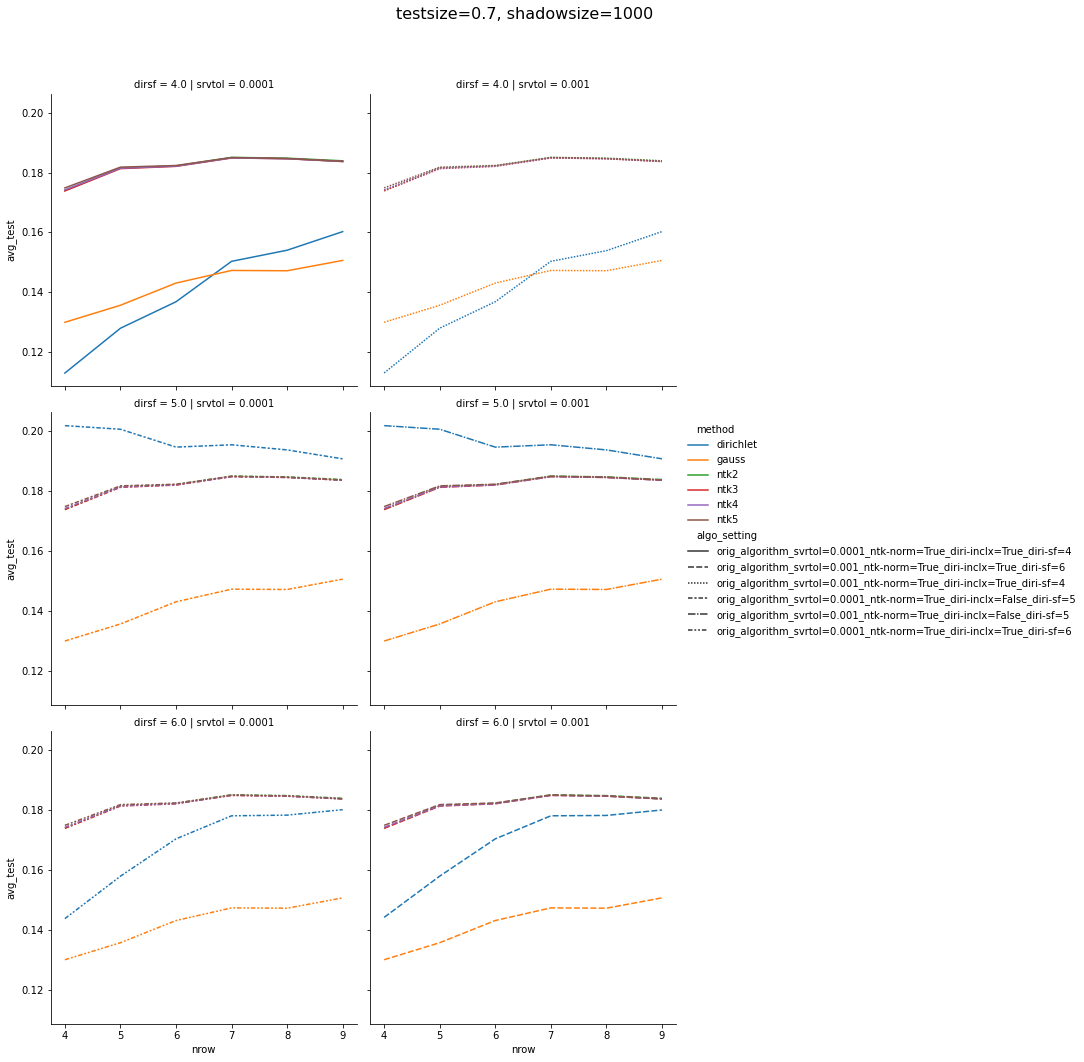

<Figure size 432x288 with 0 Axes>

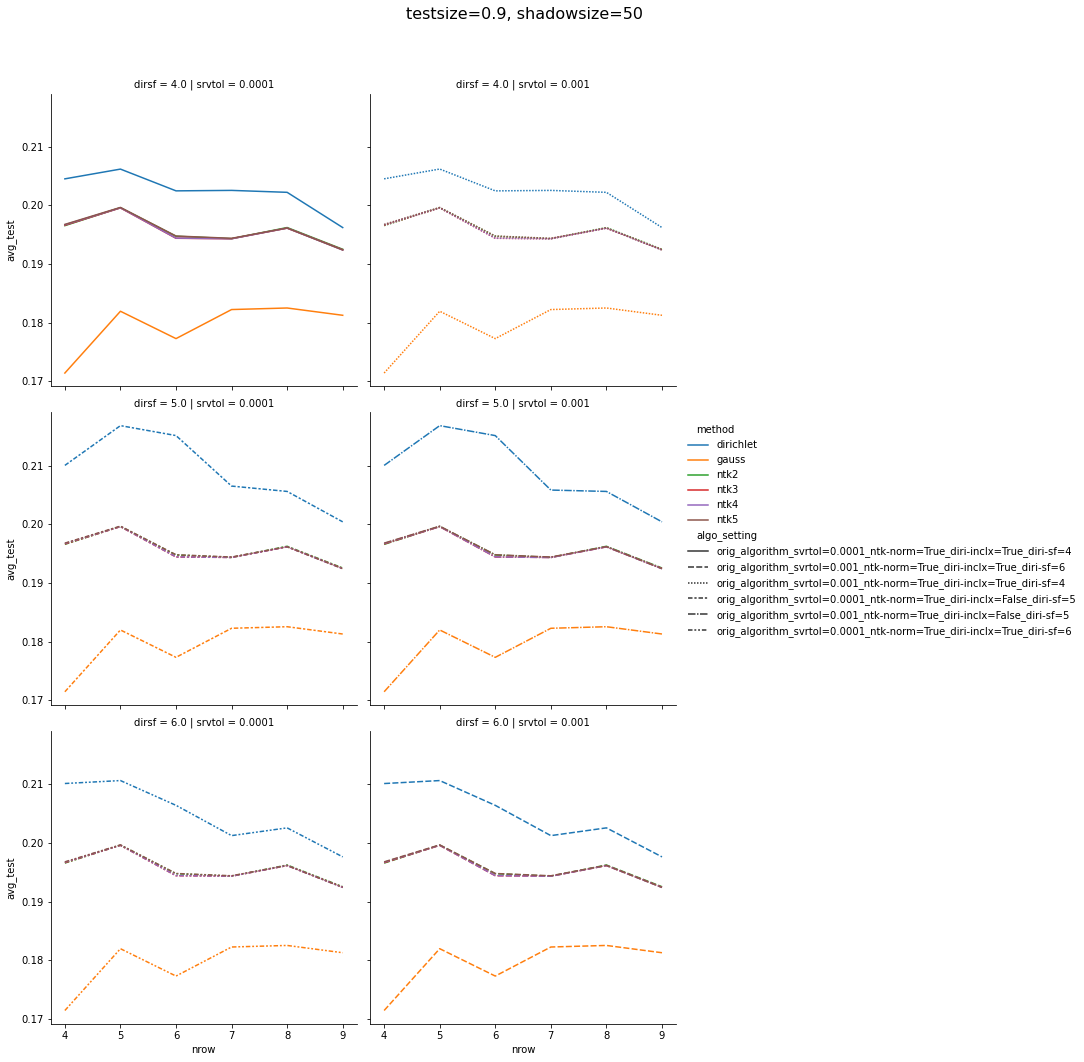

<Figure size 432x288 with 0 Axes>

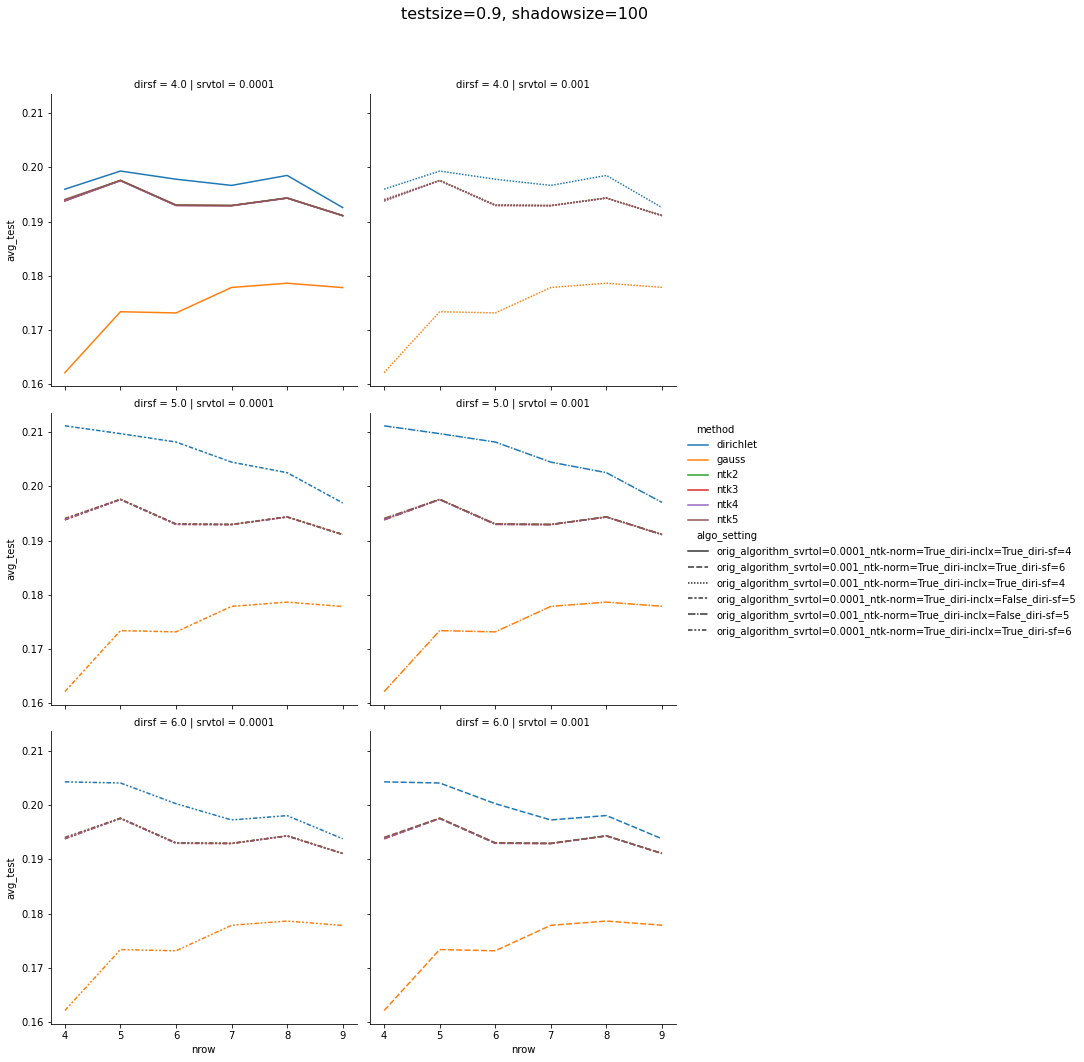

<Figure size 432x288 with 0 Axes>

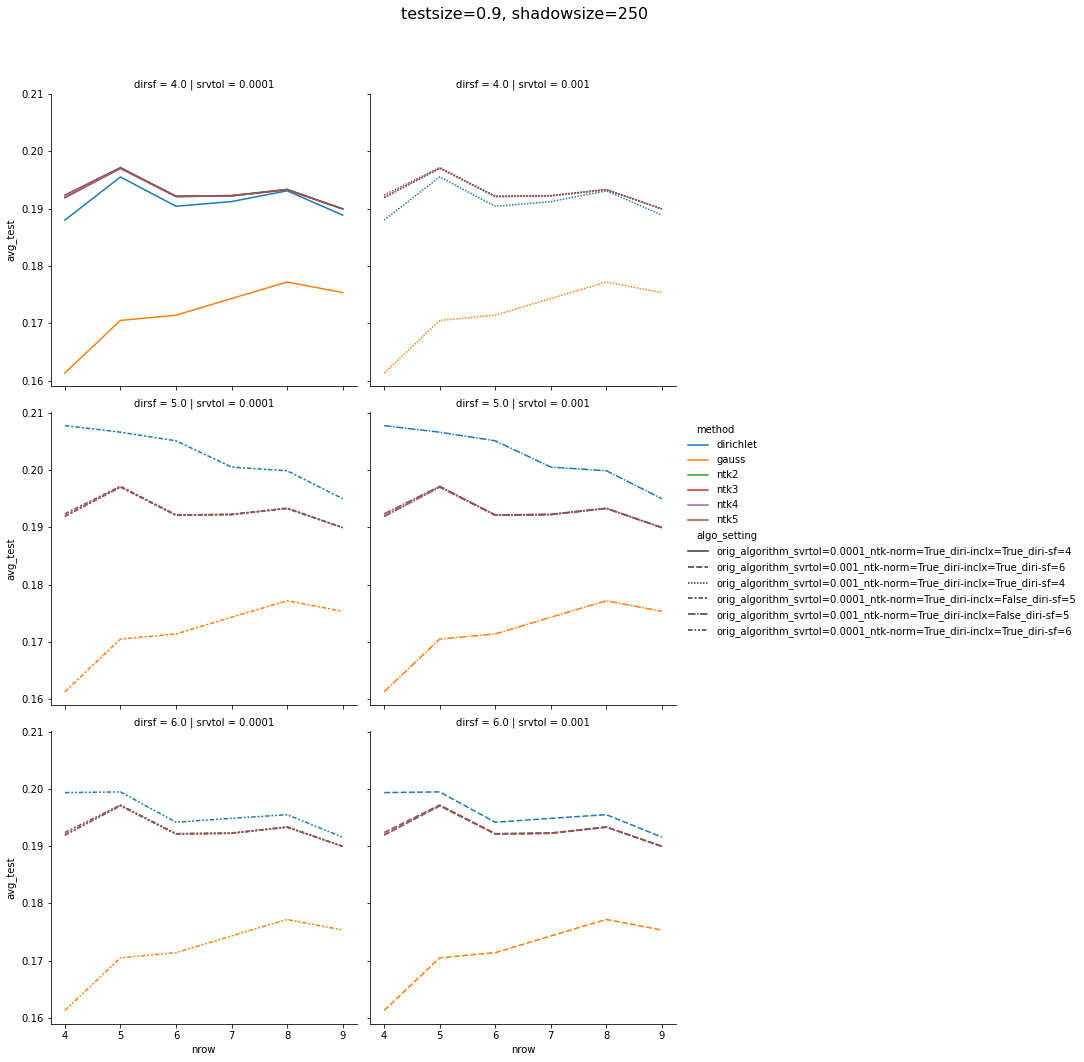

<Figure size 432x288 with 0 Axes>

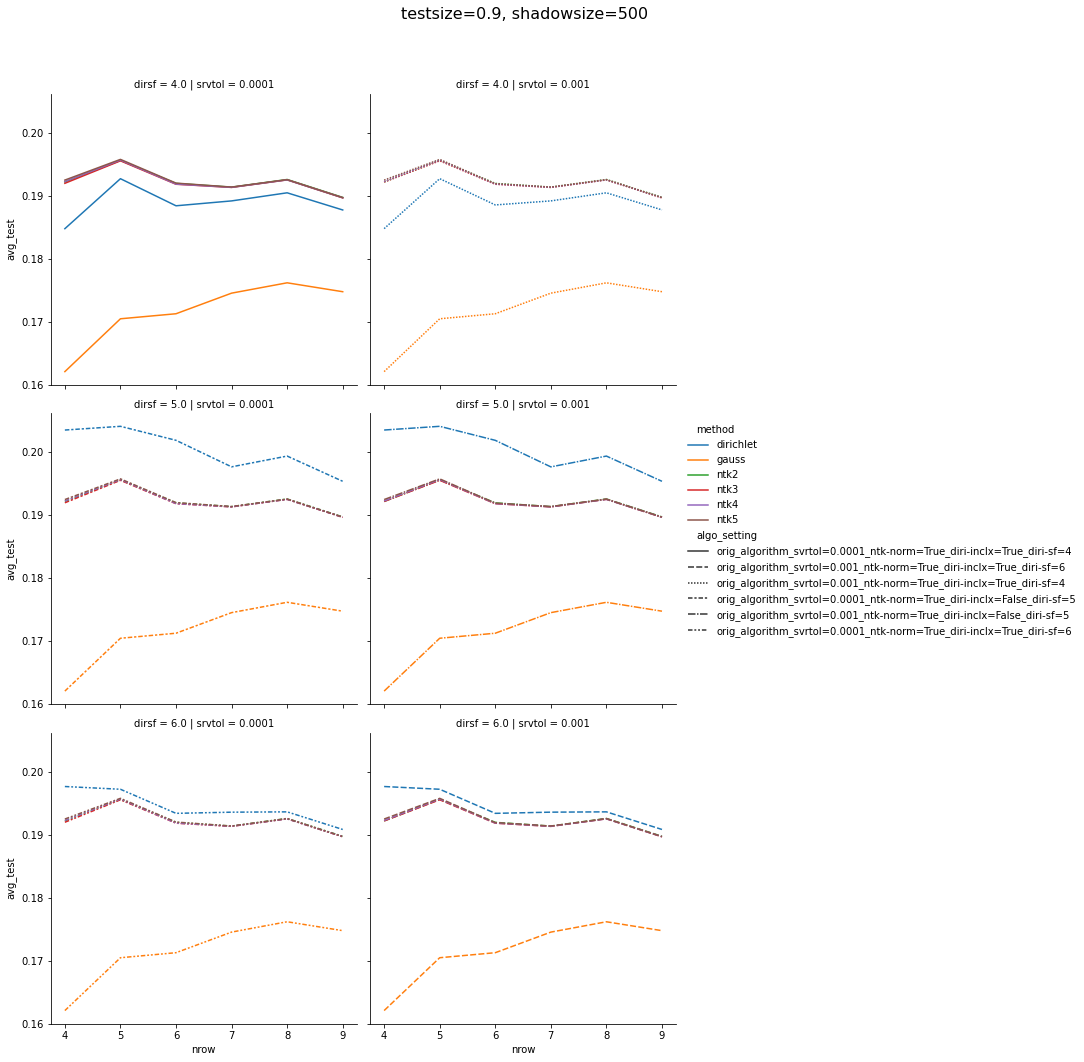

<Figure size 432x288 with 0 Axes>

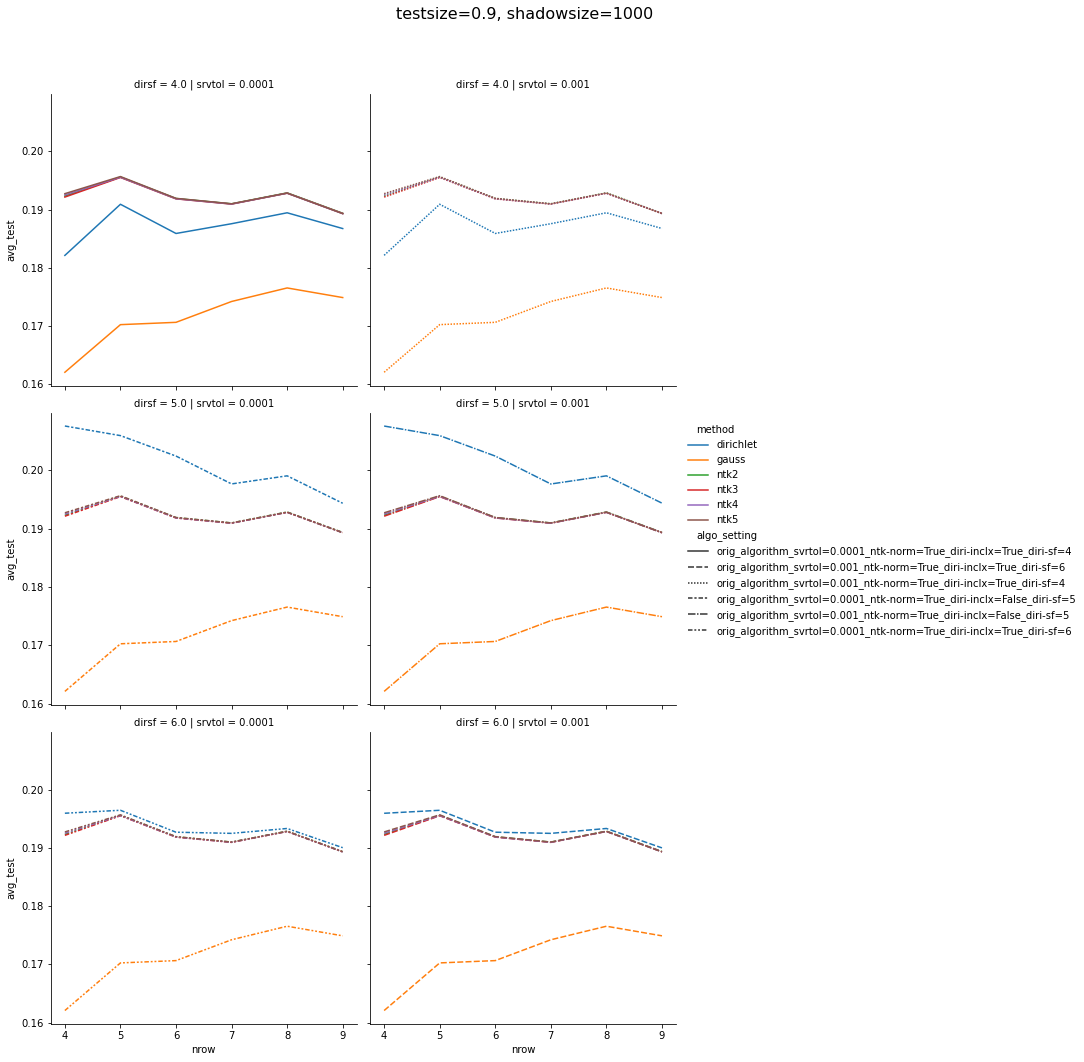

In [591]:
testsize_it = sorted(df3['testsize'].unique())
shadowsize_it = sorted(df3['shadowsize'].unique())

for testsize, shadowsize in product(testsize_it, shadowsize_it):

    plt.figure()
    df4 = df3[(df3['testsize']==testsize) & (df3['shadowsize']==shadowsize) & (df3['method'] != 'orig')]
    g = sns.relplot(
        data=df4, x='nrow', y='avg_test',
        col='srvtol', row='dirsf', style='algo_setting', hue='method',
        kind='line',
    )
    g.fig.suptitle(f'{testsize=}, {shadowsize=}', fontsize=16)
    g.fig.subplots_adjust(top=0.9)
    

## for new method

In [671]:
df = get_results('./clean_results300')
# df = get_results('./clean_results500')

  0%|          | 0/10800 [00:00<?, ?it/s]

In [672]:
df2 = df.copy()
df2 = df2[(df2['algo'] == 'new') &\
          (df2['qubitdist']==1) &\
          (df2['dataname']=='new')]

# df2 = df2[(df2['algo'] == 'orig') &\
#           (df2['shadowsize']==500) &\
#           (df2['qubitdist']==1) &\
#           (df2['nrow'] == 4) &\
#           (df2['dataname']=='new')]
# df2 = df2[(df2['dirsf'] == 4) &\
#          (df2['testsize']==0.5)]
df2 = df2.drop(columns=[c for c in df2.columns if 'best' in c])
df2 = df2.drop(columns=[c for c in df2.columns if 'test_score' in c])
df2 = df2.drop(columns=[c for c in df2.columns if 'avg_train' in c])

todrop = ['edges', 'path', 'nedges']
for c in df2.columns:
    try:
        if len(df2[c].unique()) == 1:
            todrop.append(c)
    except:
        continue
df2 = df2.drop(columns=todrop)

In [673]:
df.algo_setting.unique()

array(['new_algorithm_celer_maxiter=10000_maxep=50000_tol=0.0001',
       'new_algorithm_sklearn_maxiter=100000_tol=0.0001',
       'orig_algorithm_svrtol=0.0001_ntk-norm=True_diri-inclx=True_diri-sf=4',
       'orig_algorithm_svrtol=0.001_ntk-norm=True_diri-inclx=True_diri-sf=6',
       'orig_algorithm_svrtol=0.001_ntk-norm=True_diri-inclx=True_diri-sf=4',
       'orig_algorithm_svrtol=0.0001_ntk-norm=True_diri-inclx=False_diri-sf=5',
       'new_algorithm_celer_maxiter=10000_maxep=50000_tol=0.001',
       'new_algorithm_sklearn_maxiter=10000_tol=0.001',
       'orig_algorithm_svrtol=0.001_ntk-norm=True_diri-inclx=False_diri-sf=5',
       'orig_algorithm_svrtol=0.0001_ntk-norm=True_diri-inclx=True_diri-sf=6',
       'new_algorithm_sklearn_maxiter=10000_tol=0.0001',
       'new_algorithm_celer_maxiter=50000_maxep=50000_tol=0.0001'],
      dtype=object)

In [674]:
df2.algo_setting.unique()

array(['new_algorithm_celer_maxiter=10000_maxep=50000_tol=0.0001',
       'new_algorithm_sklearn_maxiter=100000_tol=0.0001',
       'new_algorithm_celer_maxiter=10000_maxep=50000_tol=0.001',
       'new_algorithm_sklearn_maxiter=10000_tol=0.001',
       'new_algorithm_sklearn_maxiter=10000_tol=0.0001',
       'new_algorithm_celer_maxiter=50000_maxep=50000_tol=0.0001'],
      dtype=object)

In [549]:
df2.columns

Index(['lassolib', 'maxiter', 'maxep', 'tol', 'testsize', 'shadowsize', 'nrow',
       'algo_setting', 'nsamples', 'avg_test_new'],
      dtype='object')

In [550]:
display(len(df2))
df2.head()


900

lassolib  maxiter    maxep     tol  testsize  shadowsize  nrow  \
0    celer  10000.0  50000.0  0.0001       0.9         100     4   
2    celer  10000.0  50000.0  0.0001       0.9         100     8   
3    celer  10000.0  50000.0  0.0001       0.9         100     9   
5    celer  10000.0  50000.0  0.0001       0.9         100     5   
7    celer  10000.0  50000.0  0.0001       0.9         100     7   

                                               algo_setting  nsamples  \
0  new_algorithm_celer_maxiter=10000_maxep=50000_tol=0.0001     450.0   
2  new_algorithm_celer_maxiter=10000_maxep=50000_tol=0.0001     450.0   
3  new_algorithm_celer_maxiter=10000_maxep=50000_tol=0.0001     450.0   
5  new_algorithm_celer_maxiter=10000_maxep=50000_tol=0.0001     450.0   
7  new_algorithm_celer_maxiter=10000_maxep=50000_tol=0.0001     450.0   

   avg_test_new  
0      0.165743  
2      0.169488  
3      0.169951  
5      0.168691  
7      0.170084

<Figure size 432x288 with 0 Axes>

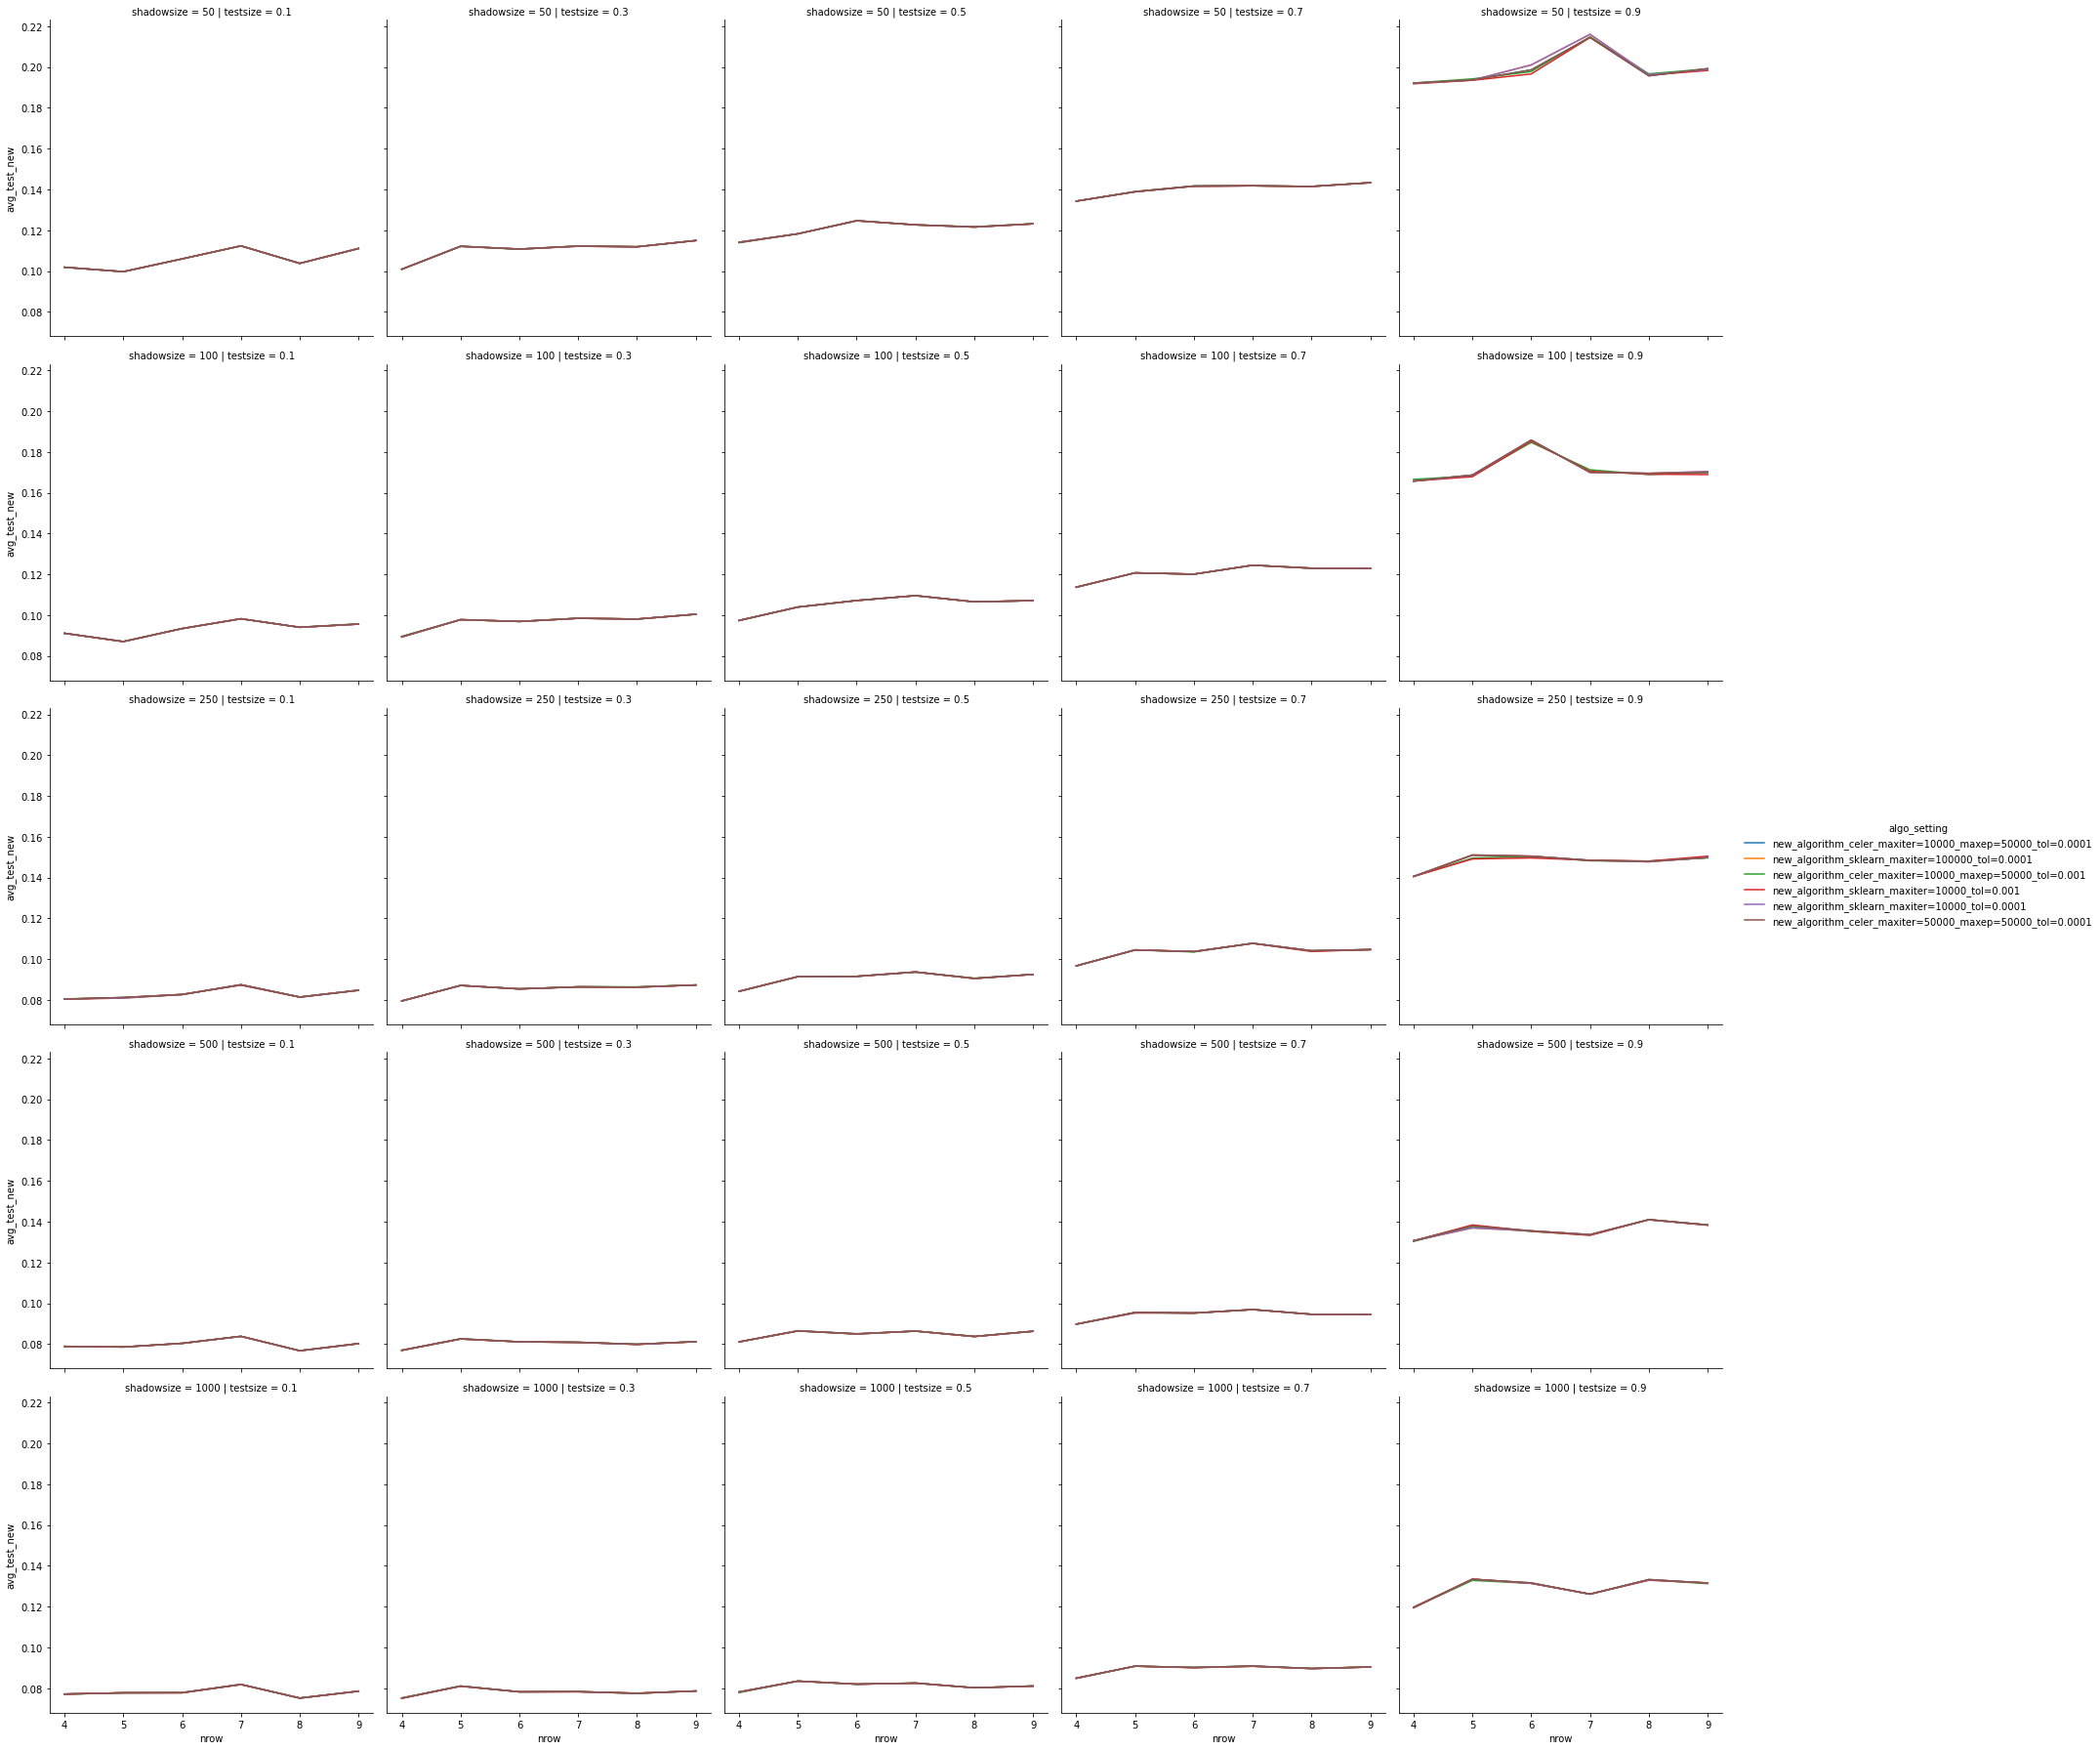

In [558]:
testsize_it = sorted(df3['testsize'].unique())
shadowsize_it = sorted(df3['shadowsize'].unique())

testsize = testsize_it[0]
shadowsize = shadowsize_it[0]

plt.figure()
#df3 = df2[(df2['testsize']==testsize) & (df2['shadowsize']==shadowsize)]
df3 = df2.copy()
g = sns.relplot(
    data=df3, x='nrow', y='avg_test_new',
    col='testsize', row='shadowsize', #style='lassolib', #hue='lassolib',
    hue='algo_setting',
    kind='line',
)

<Figure size 432x288 with 0 Axes>

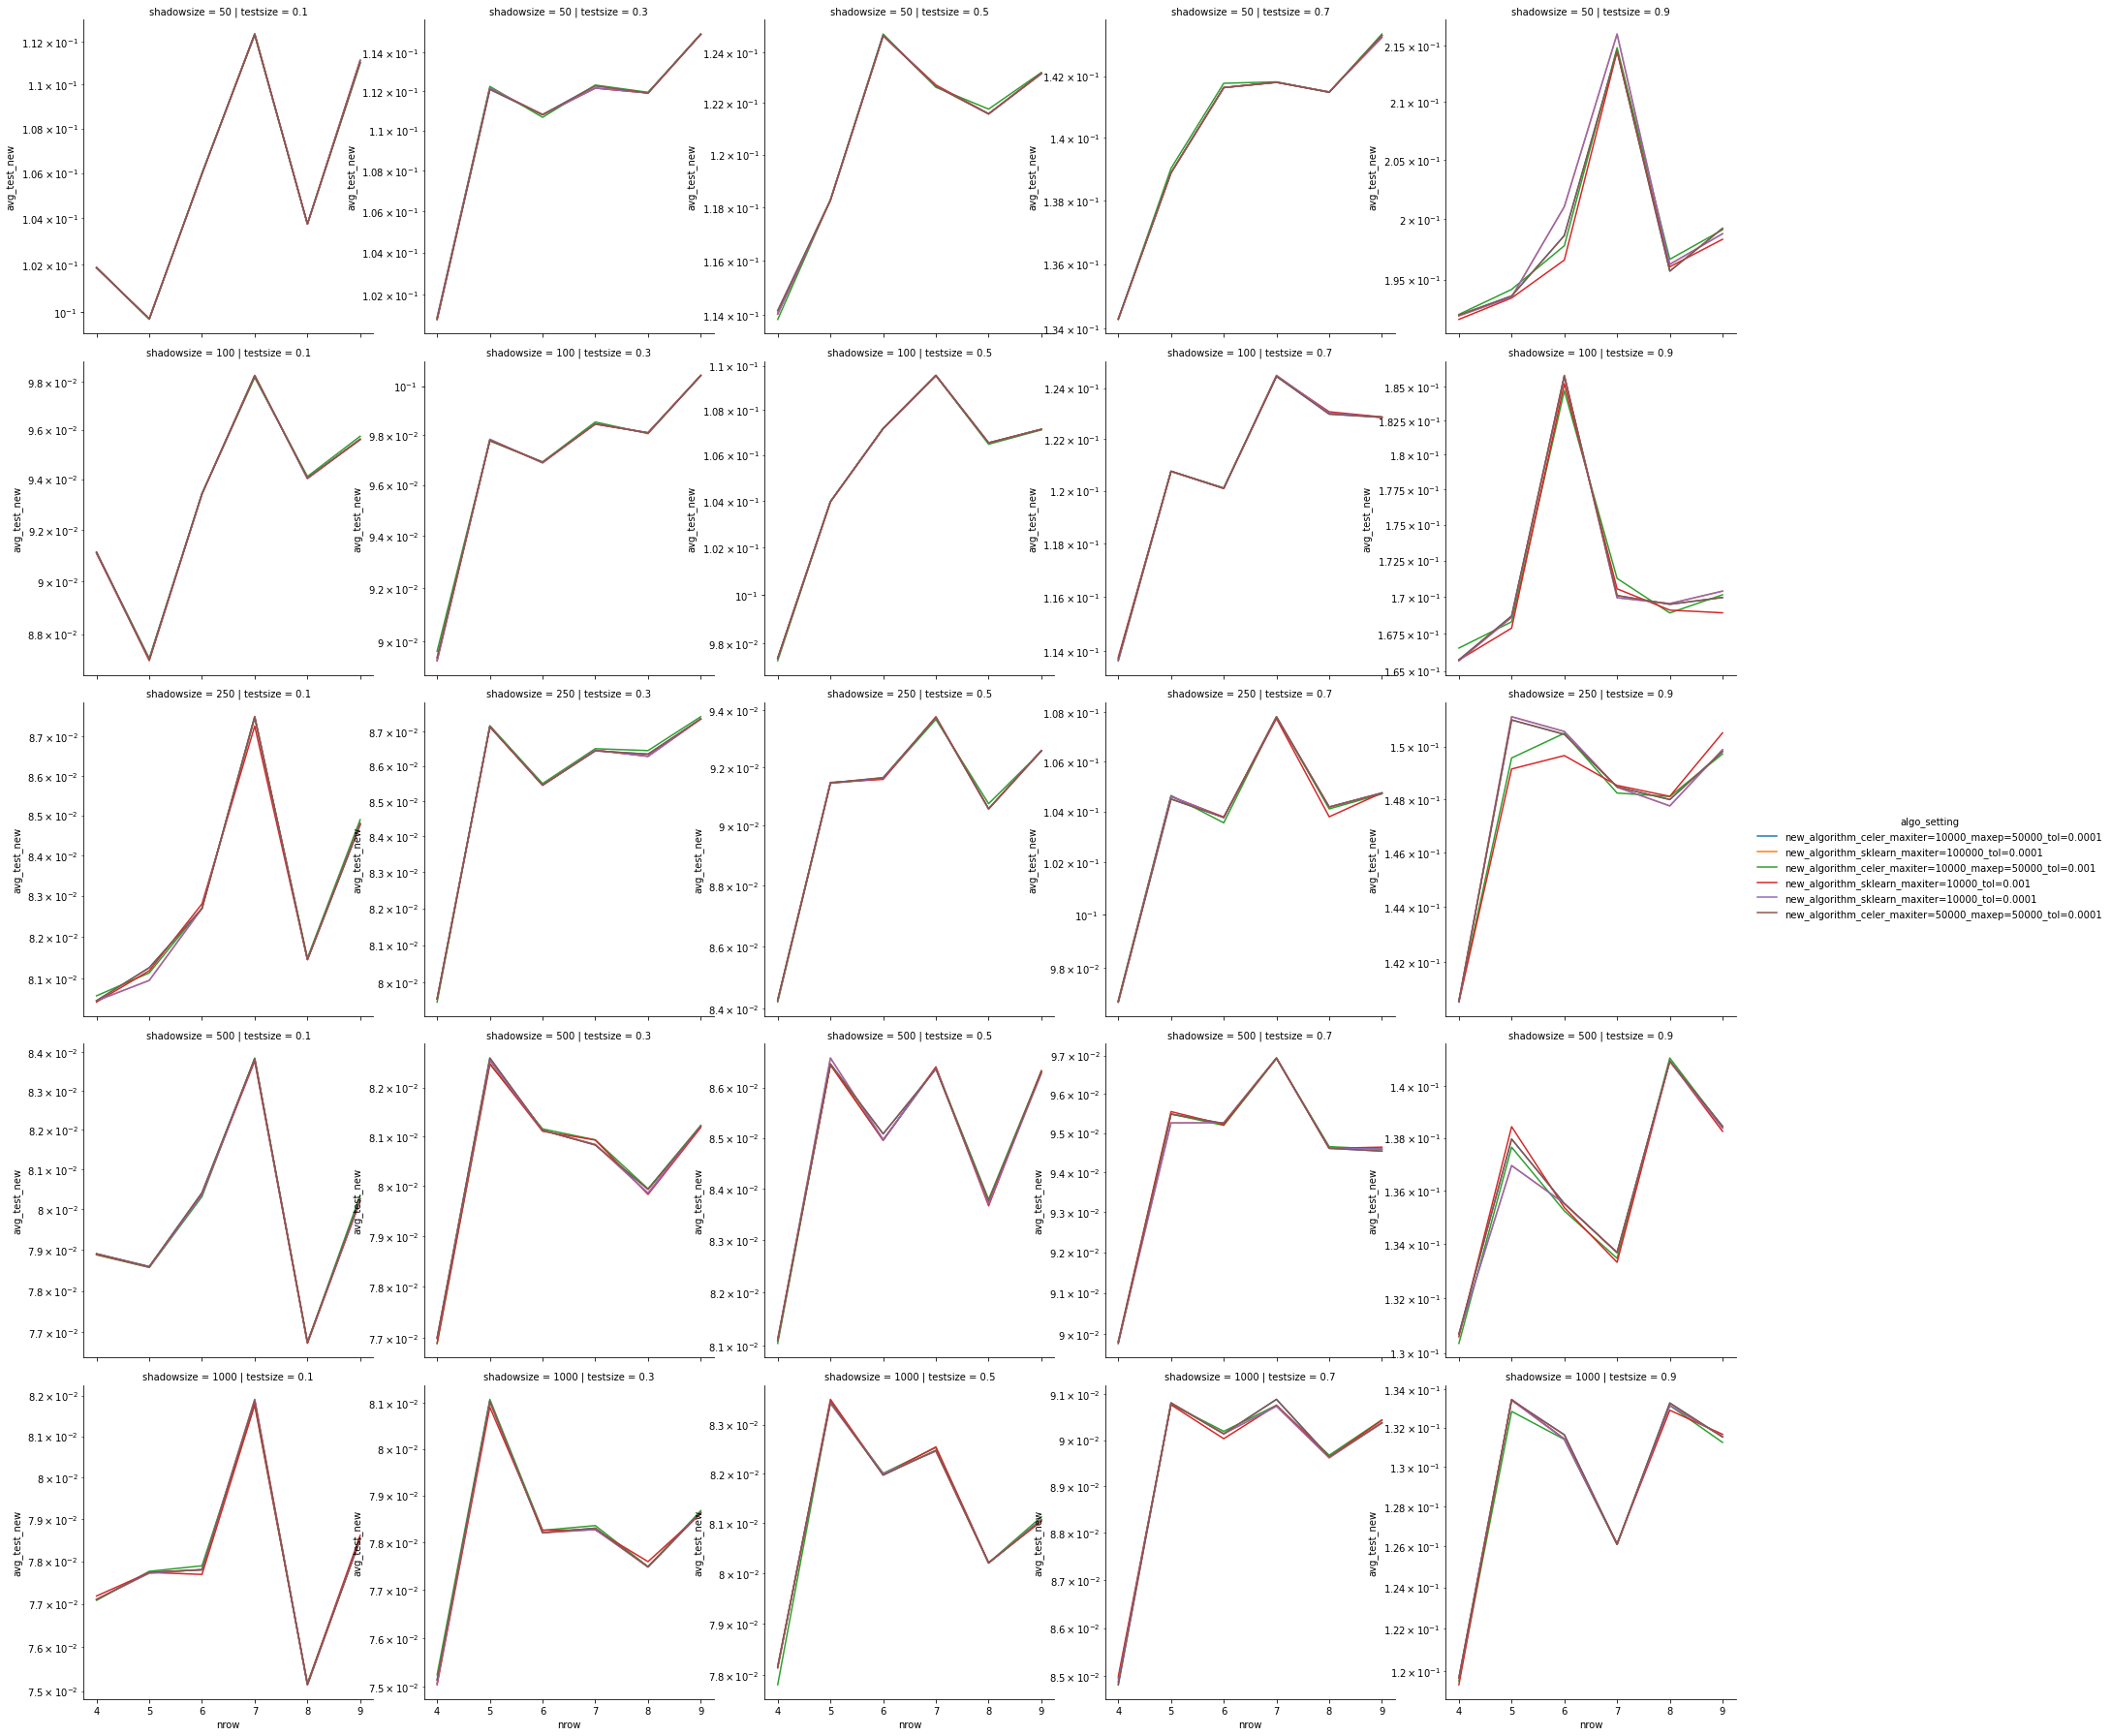

In [571]:
plt.figure()
#df3 = df2[(df2['testsize']==testsize) & (df2['shadowsize']==shadowsize)]
df3 = df2.copy()
g = sns.relplot(
    data=df3, x='nrow', y='avg_test_new',
    col='testsize', row='shadowsize', #style='lassolib', #hue='lassolib',
    hue='algo_setting',
    kind='line',
    facet_kws={'sharey': False, 'sharex': True}
)
g.set(yscale="log")

<Figure size 432x288 with 0 Axes>

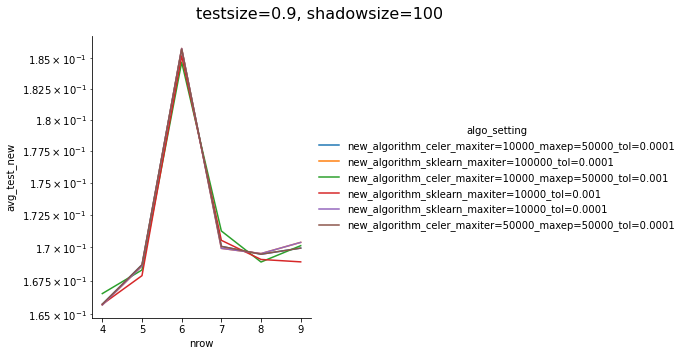

In [565]:
testsize = 0.9
shadowsize = 100

plt.figure()
df3 = df2[(df2['testsize']==testsize) & (df2['shadowsize']==shadowsize)]
g = sns.relplot(
    data=df3, x='nrow', y='avg_test_new',
    #col='tol', row='maxiter', #style='lassolib', #hue='lassolib',
    hue='algo_setting',
    kind='line',
)
g.set(yscale="log")
g.fig.suptitle(f'{testsize=}, {shadowsize=}', fontsize=16)
g.fig.subplots_adjust(top=0.9)